In [37]:
#############################################################################
# zlib License
#
# (C) 2024 Cristóvão Beirão da Cruz e Silva <cbeiraod@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

In [38]:
from pathlib import Path
import sqlite3
import pandas
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import mplhep
from math import floor

from SEUhelper import *

import pickle
import numpy
import copy
import tempfile
import shutil

from math import ceil

import sys, os
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

In [56]:
base_directory = Path("/media/daq/X9/BelgiumJune2024")
output_dir = base_directory/"AnalysisOutput"
output_dir.mkdir(exist_ok=True)
# runs = ["1","2","3","4"]
# runs = ["5","6","7","8","9","10","11","12"]
runs = ["13","14","15","16","17","18","19","20","21","22","23","24","25"]
# config_compare_dir = output_dir/"I2CConfiguration"
# config_compare_dir = output_dir/"I2CConfiguration_Kr"
# config_compare_dir = output_dir/"I2CConfiguration_Ar"
config_compare_dir = output_dir/"I2CConfiguration_Xe"
# config_compare_dir = output_dir/f"I2CConfiguration_Run{runs[0]}"
config_compare_dir.mkdir(exist_ok=True)

chip_names = [
    "ET2p01_Bare_7", # Ch0
]

config_directory = Path("/media/daq/X9/BelgiumJune2024/ETROC-Data/BelgiumJune2024/ChipConfig")
list_of_all_files = [f for f in os.listdir(config_directory) if os.path.isfile(os.path.join(config_directory,f))]

run_info = []
for run in runs:
    start_times = []
    stop_times  = []

    for chip_name in chip_names:

        for f in list_of_all_files:

            list_of_words = f.split('_')
            if(list_of_words[5].split(".")[0]!=run):continue
            read_chip_name = "_".join(list_of_words[1:4])
            if(read_chip_name!=chip_name): continue
            time_string = list_of_words[0].split("T")
            config_time = datetime.datetime.fromisoformat("T".join([time_string[0],time_string[1].replace("-", ":")]))
            if(list_of_words[4]=="PreRun"):
                start_times += [config_time]
            elif(list_of_words[4]=="PostRun"):
                stop_times+= [config_time]
    run_info += [
        {
            "name": f"Run_{run}",
            "extra_begin": start_times[-1],
            "start": start_times[-1],
            "stop": stop_times[0],
            "boards": chip_names,
            "board_channels": [0],
            "pre_config_times": start_times,
            "post_config_times": stop_times,
            "config_before": True,
            "fluence": 0.0,
        }
    ]

test_run_info =  run_info
start_time = datetime.datetime(2024, 5, 28, 0, 0, 0)
end_time = datetime.datetime(2024, 5, 28, 23, 0, 0)

# I2C Config

In [ ]:
accumulated_status_map = {}
accumulated_config_map = {}
accumulated_bitmap = {}

base_bitmap = {
}
for idx in range(32):
    base_bitmap[f'PeriCfg{idx}']  = [0 for _ in range(8)]
for idx in range(16):
    base_bitmap[f'PeriStat{idx}'] = [0 for _ in range(8)]
for idx in range(32):
    base_bitmap[f'PixCfg{idx}']   = [0 for _ in range(8)]
for idx in range(8):
    base_bitmap[f'PixStat{idx}']  = [0 for _ in range(8)]

extra_bitmap = {}

counter = 0
for this_run_idx in range(len(run_info)):
    counter += 1
    #if counter == 2:
    #    break
    #if counter < 4:
    #    continue
    this_run_info = run_info[this_run_idx]
    this_run_name = this_run_info["name"]

    this_run_dir = config_compare_dir/this_run_name
    this_run_dir.mkdir(exist_ok=True)

    for board_idx in range(len(this_run_info["boards"])):
        board_name = this_run_info["boards"][board_idx]

        if board_name not in accumulated_bitmap:
            accumulated_bitmap[board_name] = copy.deepcopy(base_bitmap)

        pre_config_time  = this_run_info[ "pre_config_times"][board_idx]
        post_config_time = this_run_info["post_config_times"][board_idx]

        if post_config_time is None:
            print(f'No post config time for board {board_name} for run {this_run_name}')
            continue

        if pre_config_time is None:
            if "config_before" in this_run_info and not this_run_info["config_before"]:
                for offset in range(this_run_idx):
                    previous_run_info = run_info[this_run_idx - 1 - offset]

                    previous_board_idx = None
                    for idx in range(len(previous_run_info["boards"])):
                        if board_name == previous_run_info["boards"][idx]:
                            previous_board_idx = idx
                            break

                    if previous_board_idx is None:
                        print("Perhaps this should be a break")
                        continue  #  TODO: Perhaps this should be a break

                    pre_config_time = previous_run_info["post_config_times"][previous_board_idx]

                    if pre_config_time is not None:
                        break

                    if "config_before" in previous_run_info and not previous_run_info["config_before"]:
                        continue
                    break

            if pre_config_time is None:
                print(f'No pre config time for board {board_name} for run {this_run_name}')
                continue

        pre_time_tag  =  pre_config_time.isoformat().replace(":", "-")
        post_time_tag = post_config_time.isoformat().replace(":", "-")

        pre_time_file  = list(config_directory.glob(f'{pre_time_tag}*'))
        post_time_file = list(config_directory.glob(f'{post_time_tag}*'))
        if len(pre_time_file) == 0:
            print(f"Couldn't find the pre-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) == 0:
            print(f"Couldn't find the post-time configuration file for board {board_name} for run {this_run_name}")
            continue
        if len(pre_time_file) > 1:
            print(f"Found too many pre-time configuration files for board {board_name} for run {this_run_name}")
            continue
        if len(post_time_file) > 1:
            print(f"Found too many post-time configuration files for board {board_name} for run {this_run_name}")
            continue
        pre_time_file  =  pre_time_file[0]
        post_time_file = post_time_file[0]

        print(f'{this_run_name} - {board_name}')

        changed_registers = diff_chip_configs(pre_time_file, post_time_file)
        print(changed_registers)
        save_changed_config(changed_registers, this_run_dir, f"changedRegisters_{board_name.replace(' ', '_')}")

        status_map, config_map = get_pixel_bitflip_map(changed_registers)
        plot_map(status_map, f"Pixel Status Bit Flips on {board_name} during Run {this_run_name}", 'Bit Flips', this_run_dir/f"{board_name}_Status.pdf")
        plot_map(config_map, f"Pixel Config Bit Flips on {board_name} during Run {this_run_name}", 'Bit Flips', this_run_dir/f"{board_name}_Config.pdf")

        this_bitmap = copy.deepcopy(base_bitmap)
        other_bitmap = {}
        fill_bitmap(changed_registers, this_bitmap, other_bitmap)
        # save_bitmap_table(this_bitmap, this_run_dir, f"{board_name}") ## This function might be an issue because of latex

        for key in other_bitmap:
            if key not in extra_bitmap:
                extra_bitmap[key] = [0 for _ in range(8)]
            for idx in range(8):
                extra_bitmap[key][idx] += other_bitmap[key][idx]
        for key in this_bitmap:
            for idx in range(8):
                accumulated_bitmap[board_name][key][idx] += this_bitmap[key][idx]

        if board_name not in accumulated_status_map:
            accumulated_status_map[board_name] = status_map
        else:
            for row in range(16):
                for col in range(16):
                    accumulated_status_map[board_name][row][col] += status_map[row][col]
        if board_name not in accumulated_config_map:
            accumulated_config_map[board_name] = config_map
        else:
            for row in range(16):
                for col in range(16):
                    accumulated_config_map[board_name][row][col] += config_map[row][col]

#print(extra_bitmap)
#print(accumulated_bitmap)

if len(extra_bitmap) != 0:
    with open(config_compare_dir/("extra_registers_bitflips.pickle"), "wb") as file:
        pickle.dump(extra_bitmap, file)

    with open(config_compare_dir/("extra_registers_bitflips.txt"), "w") as file:
        file.write("The bits in unnamed registers saw the following amount of bit flips:")
        for register in extra_bitmap:
            file.write(f" - {register}: {extra_bitmap[register]}")

# This function might be an issue because of latex
total_bitmap = copy.deepcopy(base_bitmap)
for board_name in accumulated_bitmap:
    save_bitmap_table(accumulated_bitmap[board_name], config_compare_dir, f"{board_name}") ## This function might be an issue because of latex
    for key in accumulated_bitmap[board_name]:
        for idx in range(8):
            total_bitmap[key][idx] += accumulated_bitmap[board_name][key][idx]
save_bitmap_table(total_bitmap, config_compare_dir, "Total") ## This function might be an issue because of latex

for board_name in accumulated_status_map:
    plot_map(accumulated_status_map[board_name], f"Pixel Status Bit Flips on {board_name} over all Runs", 'Bit Flips', config_compare_dir/f"{board_name}_Status.pdf")
for board_name in accumulated_config_map:
    plot_map(accumulated_config_map[board_name], f"Pixel Config Bit Flips on {board_name} over all Runs", 'Bit Flips', config_compare_dir/f"{board_name}_Config.pdf")


# Data

In [48]:
from beamtest_analysis_helper import DecodeBinary
from beamtest_analysis_helper import return_hist, return_event_hist, plot_1d_TDC_histograms
from natsort import natsorted

translated_dir = output_dir/"Translated"
translated_dir.mkdir(exist_ok=True)
plot_dir = output_dir/"TDCPlots"
plot_dir.mkdir(exist_ok=True)

## Translate RAW data

In [ ]:
def translateRun(this_run_info: dict, save_dir: Path):
    this_run_name = this_run_info["name"]
    this_run_dir: Path = base_directory/"ETROC-Data/BelgiumJune2024"/this_run_name

    if not this_run_dir.is_dir():
        raise RuntimeError(f"The directory for run {this_run_name} does not exist. Expected: {this_run_dir}")

    print(f"Translating data for run {this_run_name}")
    this_run_files = natsorted(list(this_run_dir.glob("loop*/TDC*")))

    decoder = DecodeBinary(
        firmware_key=0b0001,
        board_id = [0x17f0f, 0x17f0f, 0x17f0f, 0x17f0f],
        file_list = this_run_files,
        save_nem = None,
        skip_fw_filler = True,
        skip_crc_df = True,
        verbose = True
    )
    dataframe, event_dataframe, _, filler_dataframe = decoder.decode_files()
    print(f"Saving data for run {this_run_name}")

    #dataframe.to_feather(save_dir/f"{this_run_name}.feather")
    with sqlite3.connect(save_dir/f"{this_run_name}.sqlite") as sqlite3_connection:
        dataframe = dataframe.drop(columns=['bcid', 'l1a_counter'])
        dataframe.to_sql('hit_data', sqlite3_connection, if_exists='replace', index=False)
        event_dataframe.to_sql('event_data', sqlite3_connection, if_exists='replace', index=False)
        filler_dataframe.to_sql('filler_data', sqlite3_connection, if_exists='replace', index=False)

counter = 0
for this_run_info in run_info:
    translateRun(this_run_info, translated_dir)
    counter += 1
    #if counter == 2:
    #    break

# for this_run_info in extra_run_info:
#     translateRun(this_run_info, translated_dir)

# for this_run_info in test_run_info:
#     translateRun(this_run_info, translated_dir)

## Make per run TDC Plots

In [ ]:
def plotRunSummary(this_run_info: dict, translated_dir: Path, save_dir: Path, tb_loc: str, ps_see_time: datetime.datetime | None = None, print_info: bool = False):
    this_run_name = this_run_info["name"]
    this_run_dir: Path = base_directory/"ETROC-Data/BelgiumJune2024"/this_run_name
    this_run_plot_dir = save_dir/this_run_name
    this_run_plot_dir.mkdir(exist_ok=True)

    if not this_run_dir.is_dir():
        raise RuntimeError(f"The directory for run {this_run_name} does not exist. Expected: {this_run_dir}")

    #dataframe = pandas.read_feather(translated_dir/f"{this_run_name}.feather")
    with sqlite3.connect(translated_dir/f"{this_run_name}.sqlite") as sqlite3_connection:
        dataframe = pandas.read_sql('SELECT * FROM hit_data', sqlite3_connection, index_col=None)
        event_dataframe = pandas.read_sql('SELECT * FROM event_data', sqlite3_connection, index_col=None)

    if len(dataframe) == 0:
        print('dataframe is empty!')
        return

    filtered_df = dataframe.loc[(dataframe["tot"] - dataframe["tot"].mean()).abs() > 2*dataframe["tot"].std()].copy()
    off_peak_hits = len(filtered_df)

    if print_info:
        print(f"All hits on all boards: {len(dataframe)}")
        print(f"Hits not in main TOT peak: {off_peak_hits}")

    board_labels = this_run_info["boards"]
    board_names = [i.replace(" ", "_") for i in board_labels]
    board_channels = this_run_info["board_channels"]
    this_run_hists = return_hist(dataframe, board_channels, board_names, hist_bins=[100, 128, 128])
    this_event_hist = return_event_hist(event_dataframe)
    filtered_run_hists = return_hist(filtered_df, board_channels, board_names, hist_bins=[100, 128, 128])

    for board_idx in range(len(board_labels)):
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", inclusive", slide_friendly=True, event_hist=this_event_hist, save_mother_dir=this_run_plot_dir, tag="inclusive")
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", inclusive", slide_friendly=True, do_logy=True, event_hist=this_event_hist, save_mother_dir=this_run_plot_dir, tag="inclusive_logy")
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", inclusive", slide_friendly=True, event_hist=this_event_hist, save_mother_dir=this_run_plot_dir, tag="inclusive")
        plot_1d_TDC_histograms(this_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", inclusive", slide_friendly=True, do_logy=True, event_hist=this_event_hist, save_mother_dir=this_run_plot_dir, tag="inclusive_logy")

        if off_peak_hits > 0:
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", filtered TOT peak", slide_friendly=True,
                                   save_mother_dir=this_run_plot_dir, tag="filtered_tot_peak")
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", filtered TOT peak", slide_friendly=True, do_logy = True,
                                   save_mother_dir=this_run_plot_dir, tag="filtered_tot_peak_logy")
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", filtered TOT peak", slide_friendly=True,
                                   save_mother_dir=this_run_plot_dir, tag="filtered_tot_peak")
            plot_1d_TDC_histograms(filtered_run_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=", filtered TOT peak", slide_friendly=True, do_logy = True,
                                   save_mother_dir=this_run_plot_dir, tag="filtered_tot_peak_logy")

    #counts = event_dataframe['hamming_count'].unique()
    #if len(counts) > 1:
    #    for hamming_count in counts:
    #        filtered_event_df = event_dataframe.loc[event_dataframe['hamming_count'] == hamming_count]

    #        print(filtered_event_df)
    #        filtered_df = dataframe[dataframe['evt'].isin(filtered_event_df['evt'])].copy()
    #        print(filtered_df)

    values = dataframe['ea'].unique()
    if len(values) > 1:
        for hamming_code in values:
            filtered_df    = dataframe.loc[dataframe['ea'] == hamming_code].copy()
            filtered_hists = return_hist(filtered_df, board_channels, board_names, hist_bins=[100, 128, 128])

            for board_idx in range(len(board_labels)):
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=False,
                                       save_mother_dir=this_run_plot_dir, tag=f"hamming_code_{hamming_code}")
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=False, do_logy = True,
                                       save_mother_dir=this_run_plot_dir, tag=f"hamming_code_{hamming_code}_logy")
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=True,
                                       save_mother_dir=this_run_plot_dir, tag=f"hamming_code_{hamming_code}")
                plot_1d_TDC_histograms(filtered_hists, board_names[board_idx], tb_loc=tb_loc, fig_tag=f", Hamming Code {hamming_code:#04b}", slide_friendly=True, do_logy = True,
                                       save_mother_dir=this_run_plot_dir, tag=f"hamming_code_{hamming_code}_logy")

    run_start = this_run_info['start']
    run_stop  = this_run_info['stop']

    ##   It seems that after the PS SEE, data was no longer being recorded, so it doesn't
    ## make sense to filter the events based on the fraction of total events between good
    ## events (before PS SEE) and bad events (after PS SEE)
    #if ps_see_time > run_start and ps_see_time < run_stop:
    #    run_duration = (run_stop - run_start)
    #    percentage_good = (ps_see_time - run_start)/run_duration

    #    total_rows = len(dataframe)
    #    good_rows = floor(total_rows * percentage_good * 0.95)  # Add a 5% safety factor
    #    bad_rows = floor(total_rows * (1 - percentage_good) * 0.95)

    #    good_df = dataframe.iloc[:good_rows]
    #    bad_df = dataframe.iloc[-bad_rows:]

    #    good_run_hists = return_hist(good_df, board_names, board_channels, hist_bins=[100, 128, 128])
    #    bad_run_hists  = return_hist(bad_df, board_names, board_channels, hist_bins=[100, 128, 128])

    #    for board_idx in range(len(board_labels)):
    #        #plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_good", fig_tag=" good, inclusive", slide_friendly=False)
    #        plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_good", fig_tag=" good, inclusive", slide_friendly=True, event_hist=this_event_hist)
    #        plot_1d_TDC_histograms(good_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy_good", fig_tag=" good, inclusive", slide_friendly=True, do_logy = True, event_hist=this_event_hist)

    #        #plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_bad", fig_tag=" bad, inclusive", slide_friendly=False)
    #        plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_bad", fig_tag=" bad, inclusive", slide_friendly=True, event_hist=this_event_hist)
    #        plot_1d_TDC_histograms(bad_run_hists, board_names[board_idx], board_names[board_idx], board_labels[board_idx], this_run_plot_dir, save=True, tag="inclusive_logy_bad", fig_tag=" bad, inclusive", slide_friendly=True, do_logy = True, event_hist=this_event_hist)

counter = 0
for this_run_info in run_info:
    counter += 1
    print(f"""Run {counter} {this_run_info["name"]}""")
    #if counter == 12:
    #    break
    #if counter < 11:
    #    continue
    plotRunSummary(this_run_info, translated_dir, plot_dir, "louvain", True)

# for this_run_info in extra_run_info:
#     plotRunSummary(this_run_info, translated_dir, plot_dir, ps_see_time)

# for this_run_info in test_run_info:
#     plotRunSummary(this_run_info, translated_dir, plot_dir, ps_see_time)


## Make trigger rate plot

In [44]:
from beamtest_analysis_helper import load_fig_title
import mplhep as hep
hep.style.use('CMS')

Run 1 Run_01
Run 2 Run_1
Run 3 Run_2
Run 4 Run_3
Run 5 Run_4
Run 6 Run_5
Run 7 Run_6
Run 8 Run_7
Run 9 Run_8
Run 10 Run_9
Run 11 Run_10
Run 12 Run_11
Run 13 Run_12
Run 14 Run_13
Run 15 Run_14
Run 16 Run_15
Run 17 Run_16
Run 18 Run_17
Run 19 Run_18
Run 20 Run_19
Run 21 Run_20
Run 22 Run_21
Run 23 Run_22


/tmp/ipykernel_452404/1899295188.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(33, 11))


Run 24 Run_23
Run 25 Run_24
Run 26 Run_25


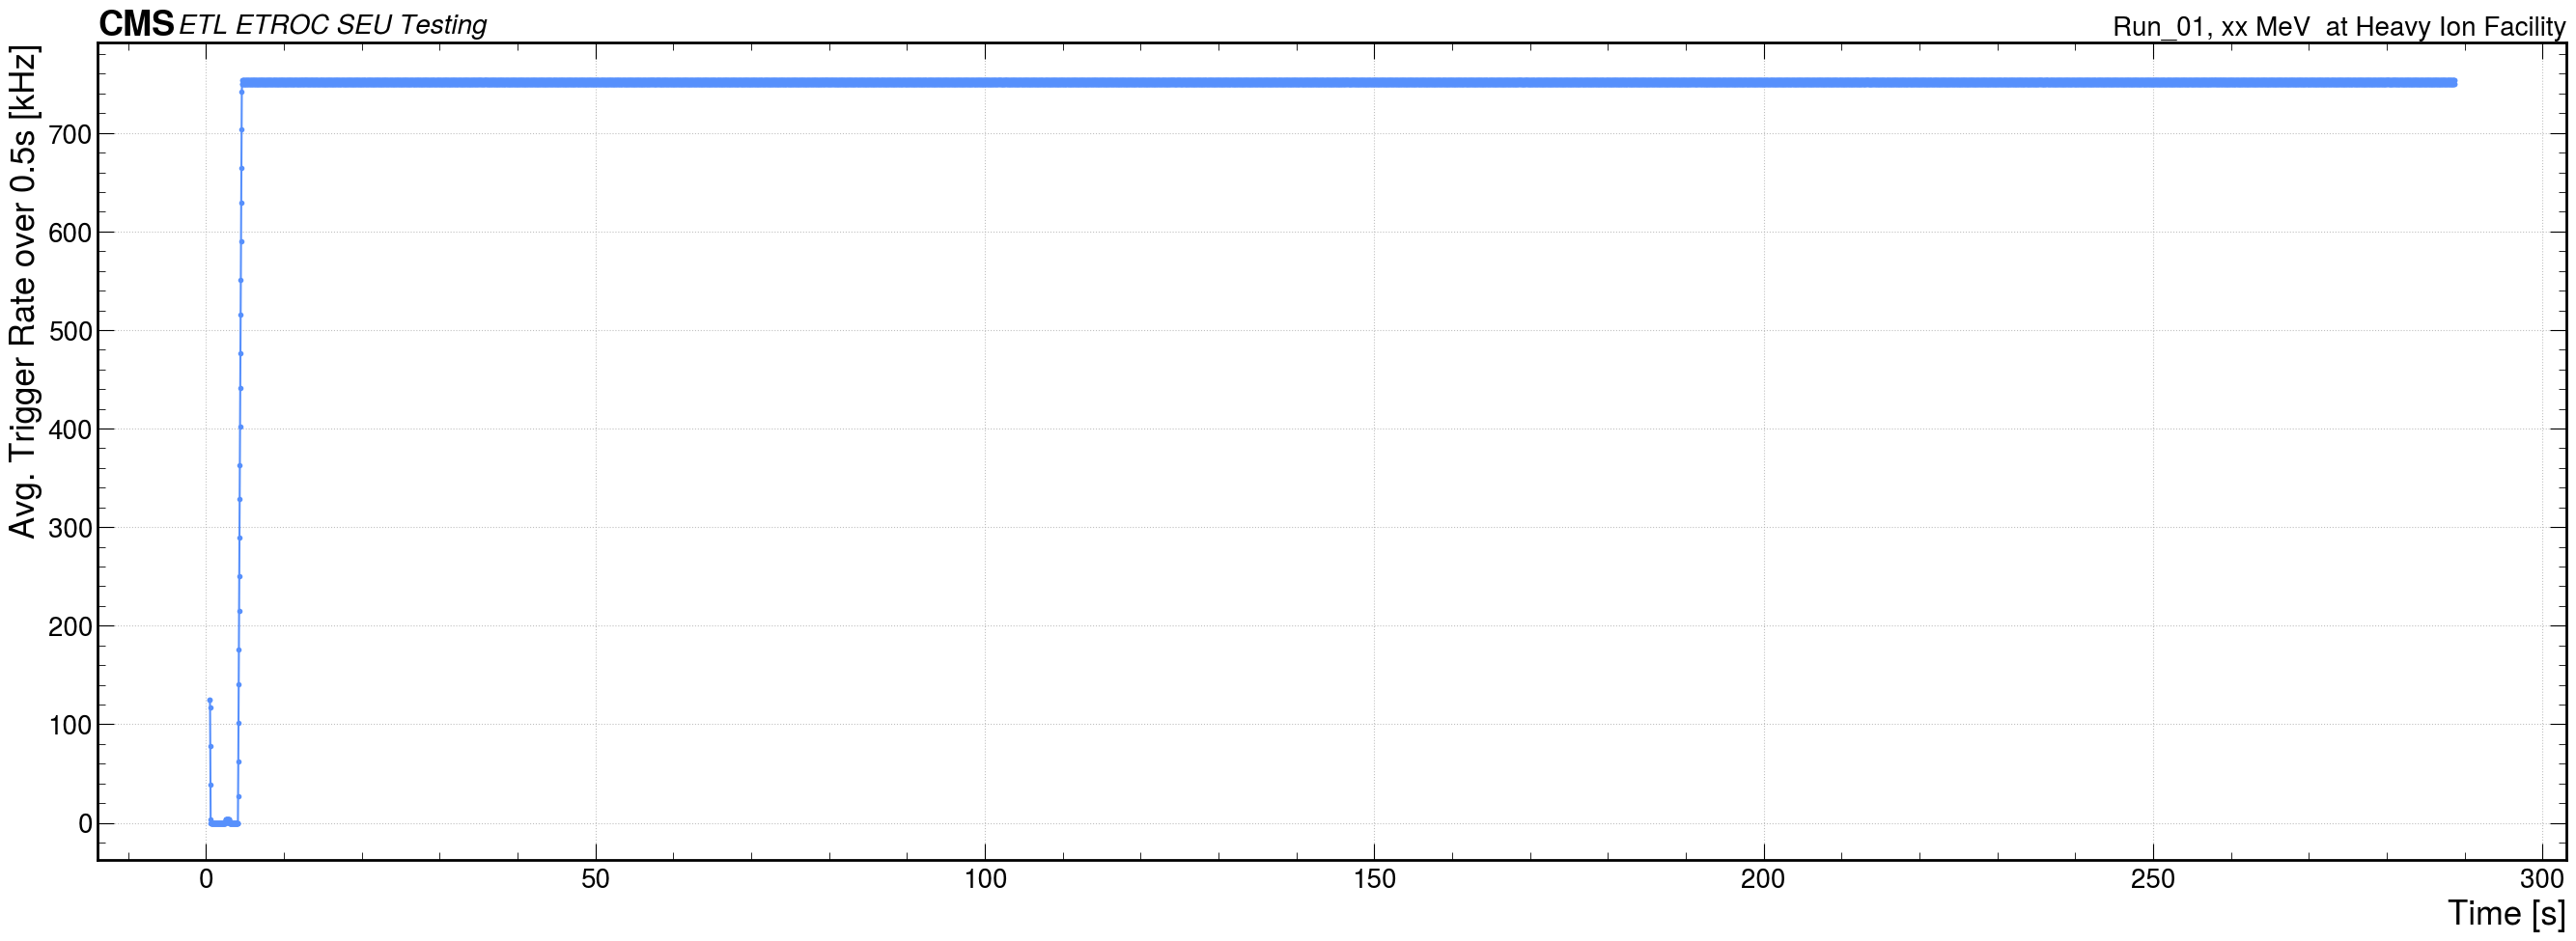

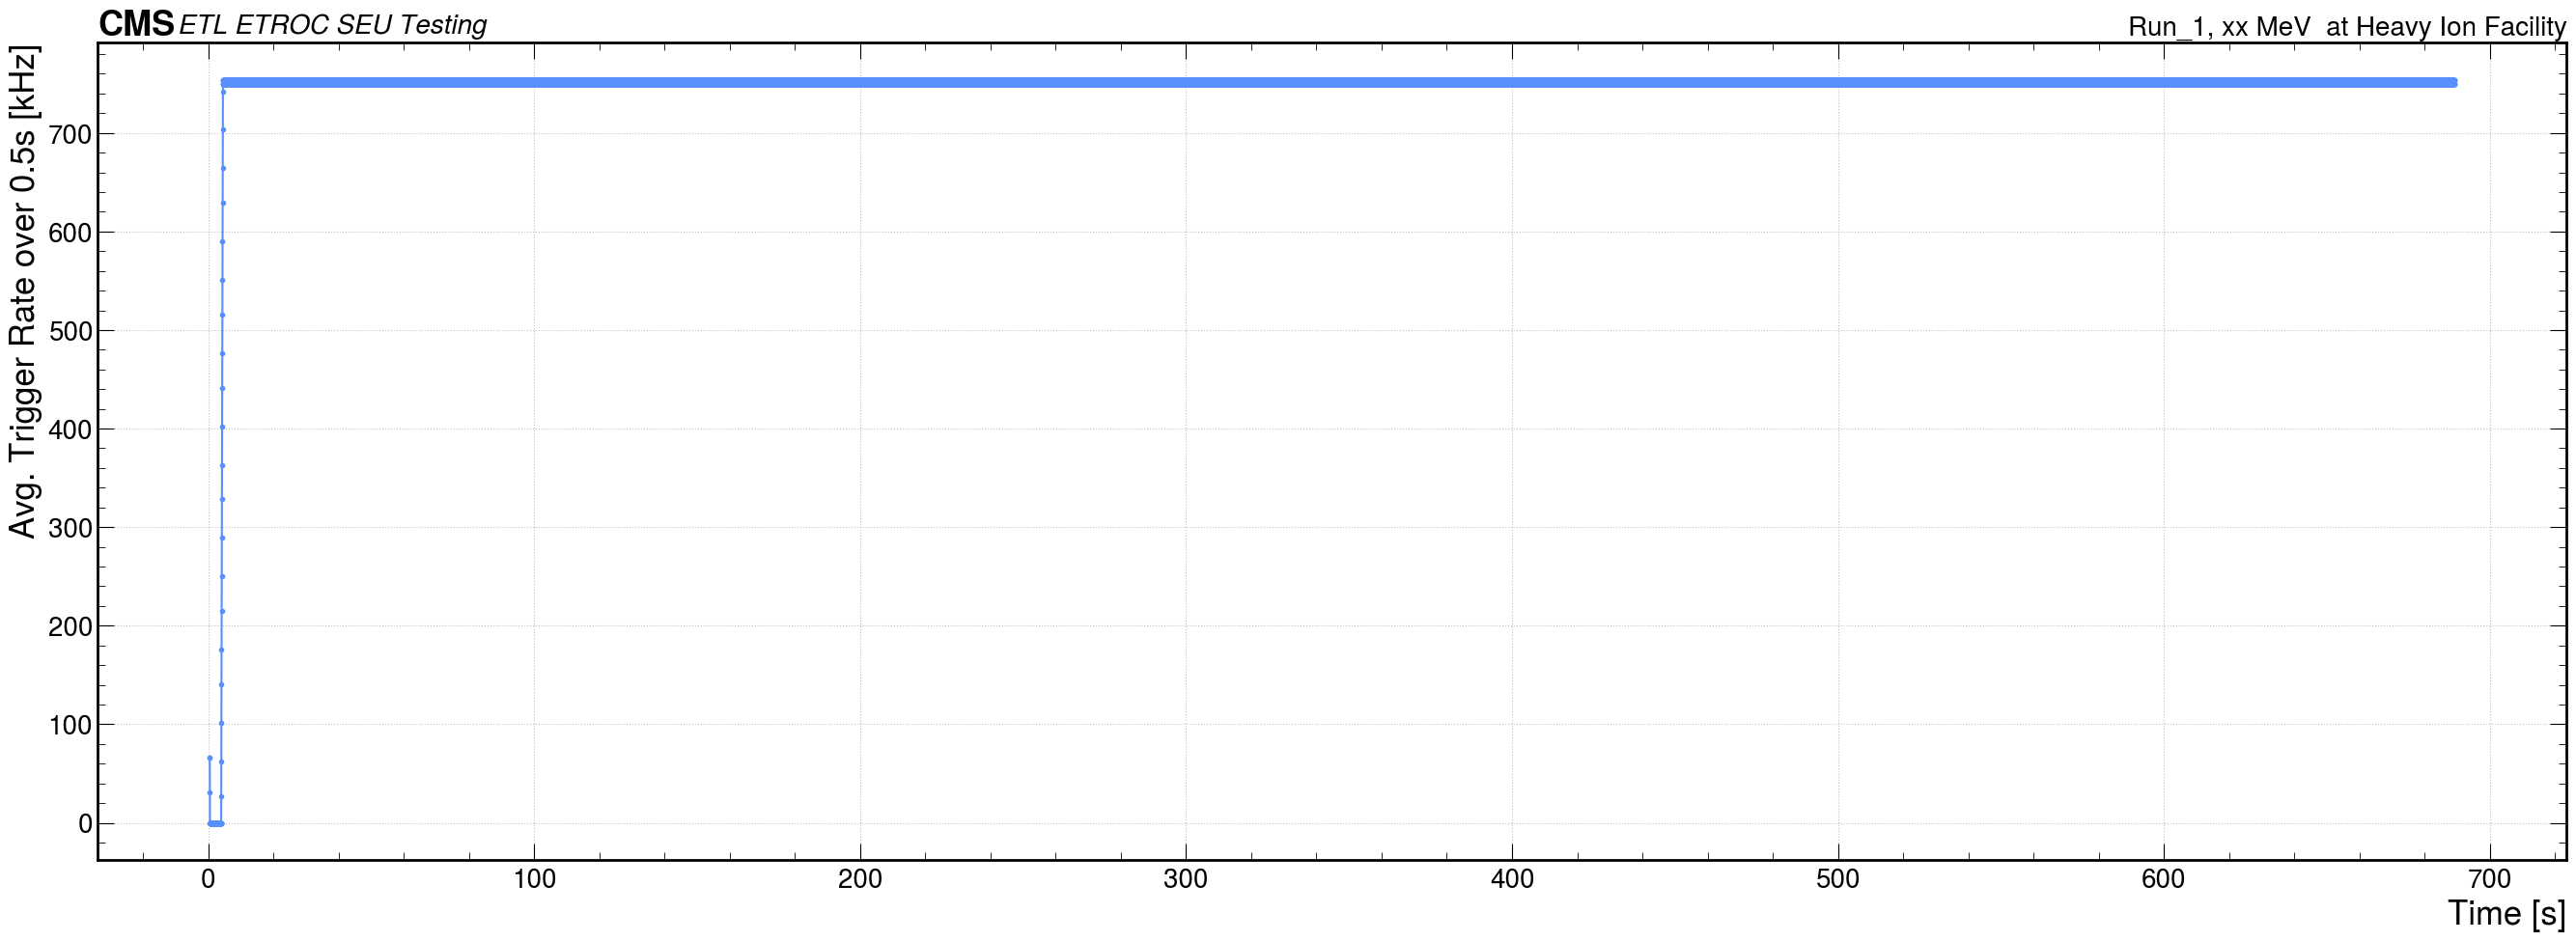

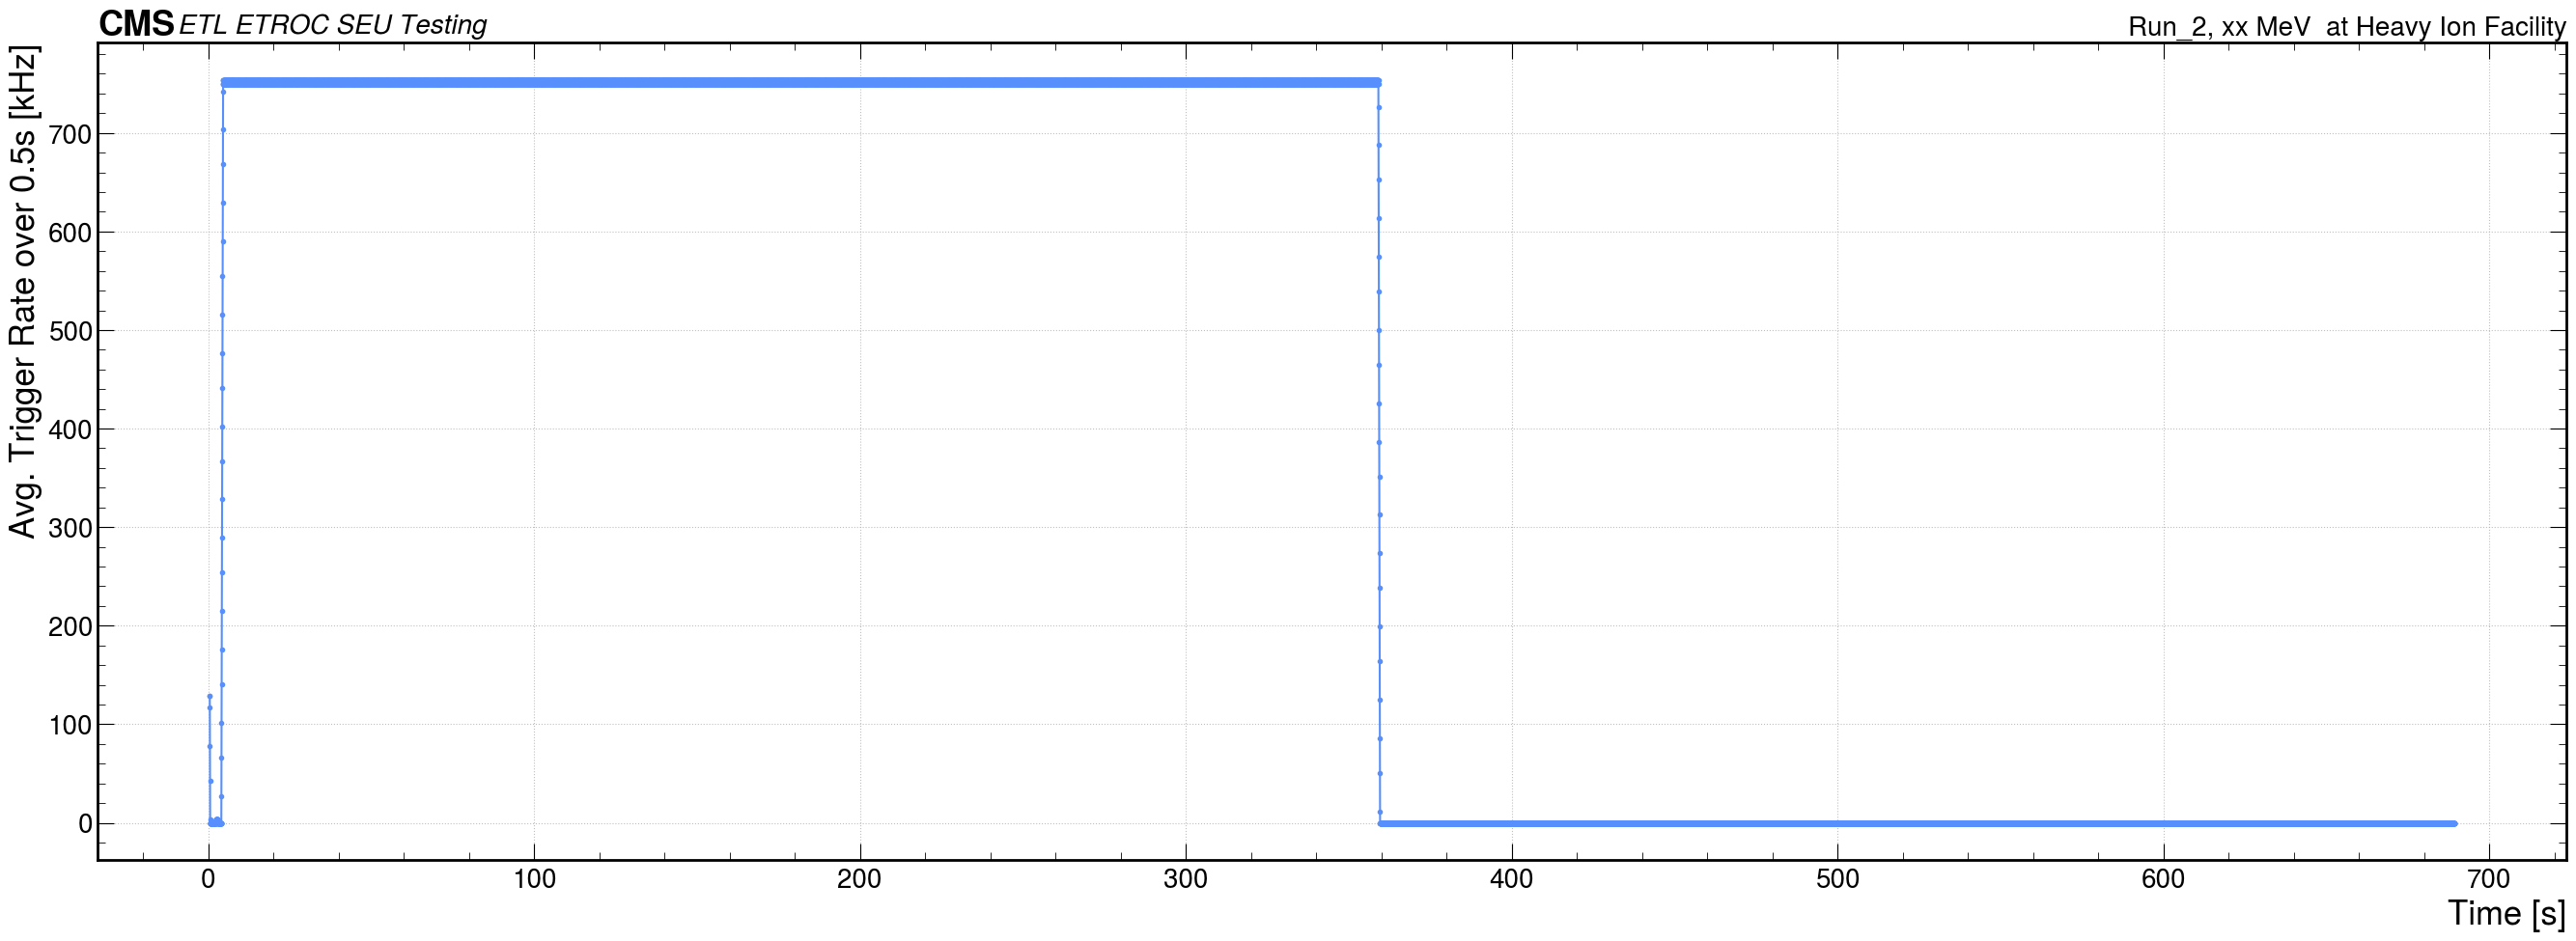

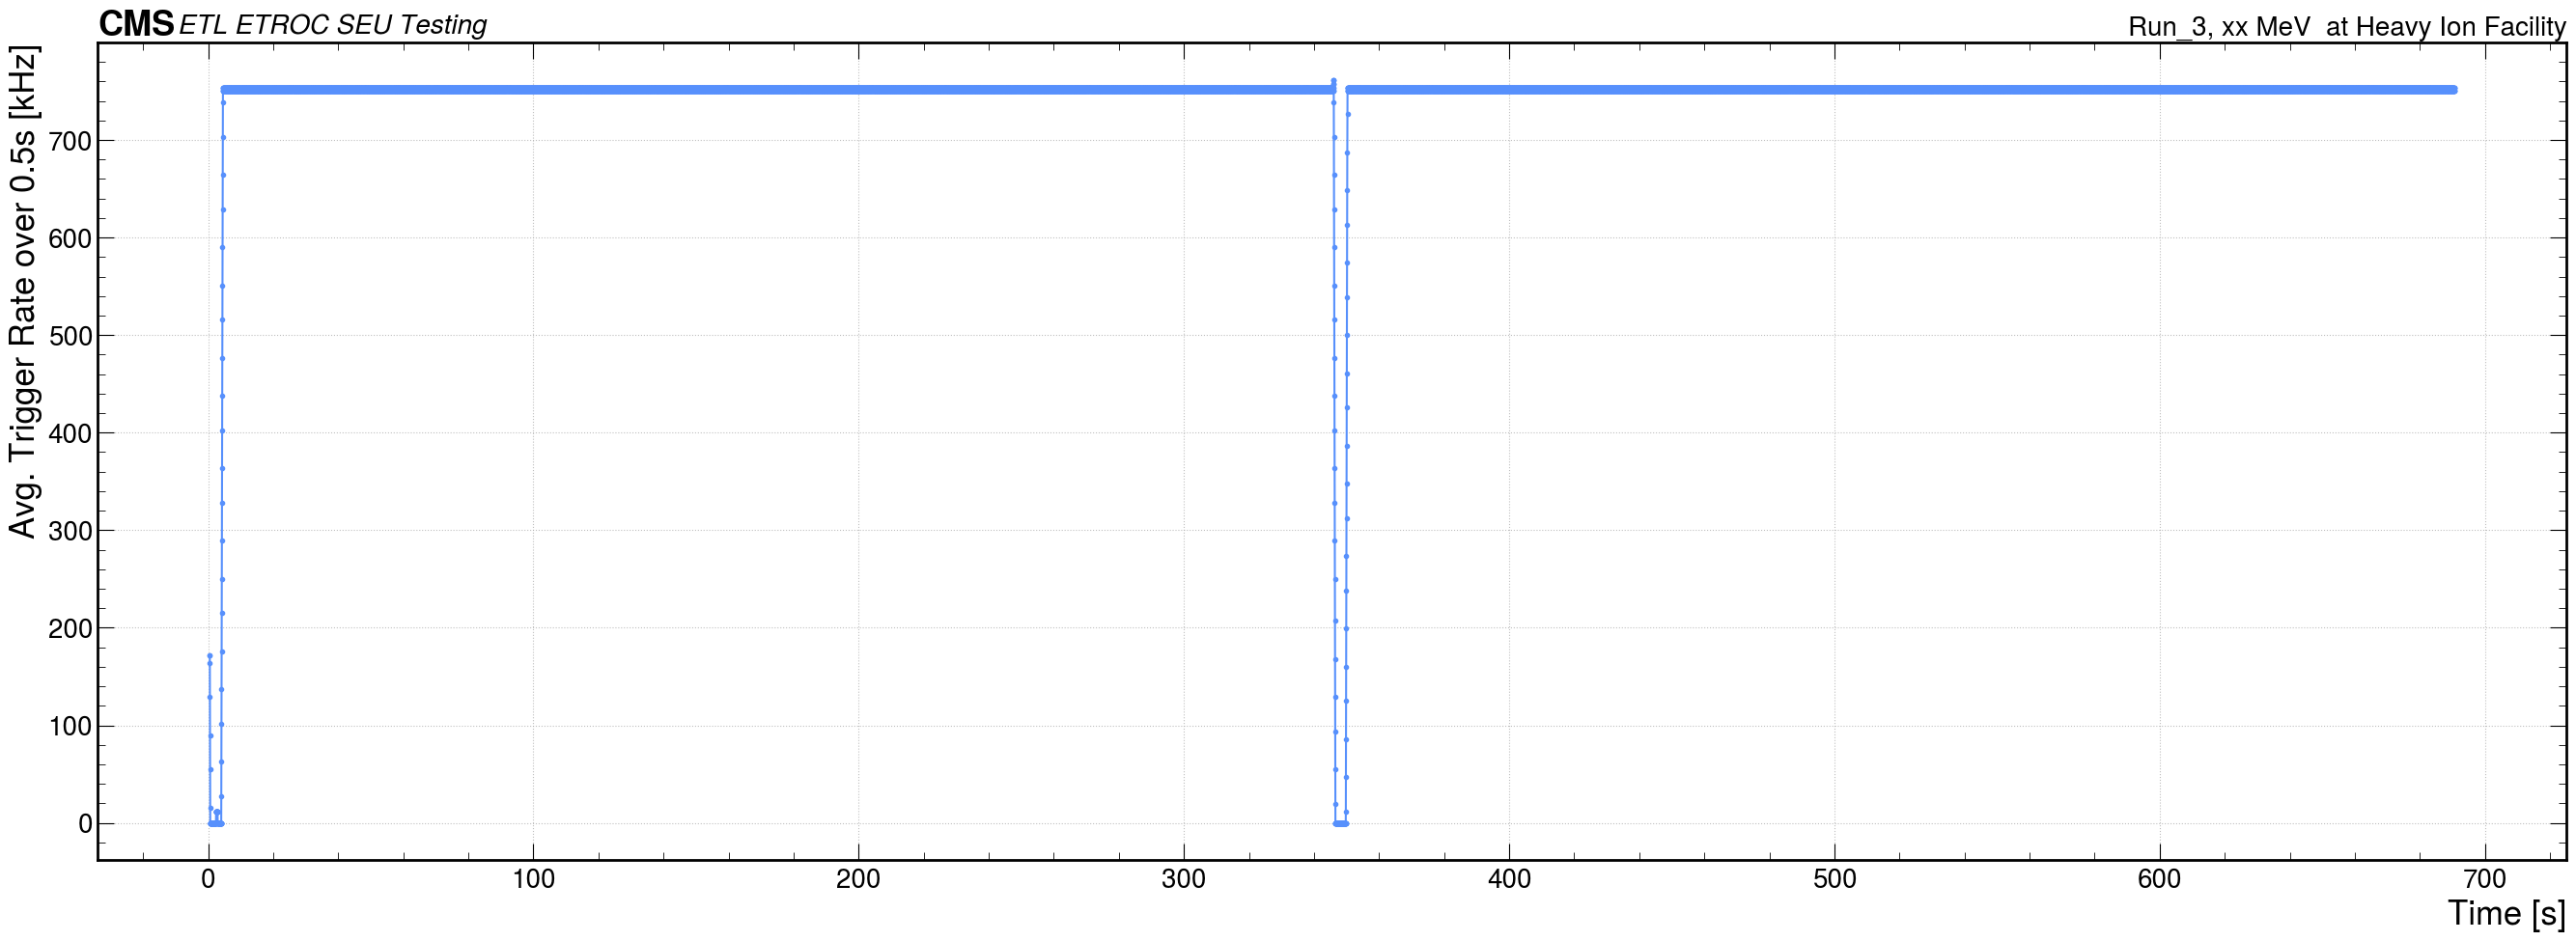

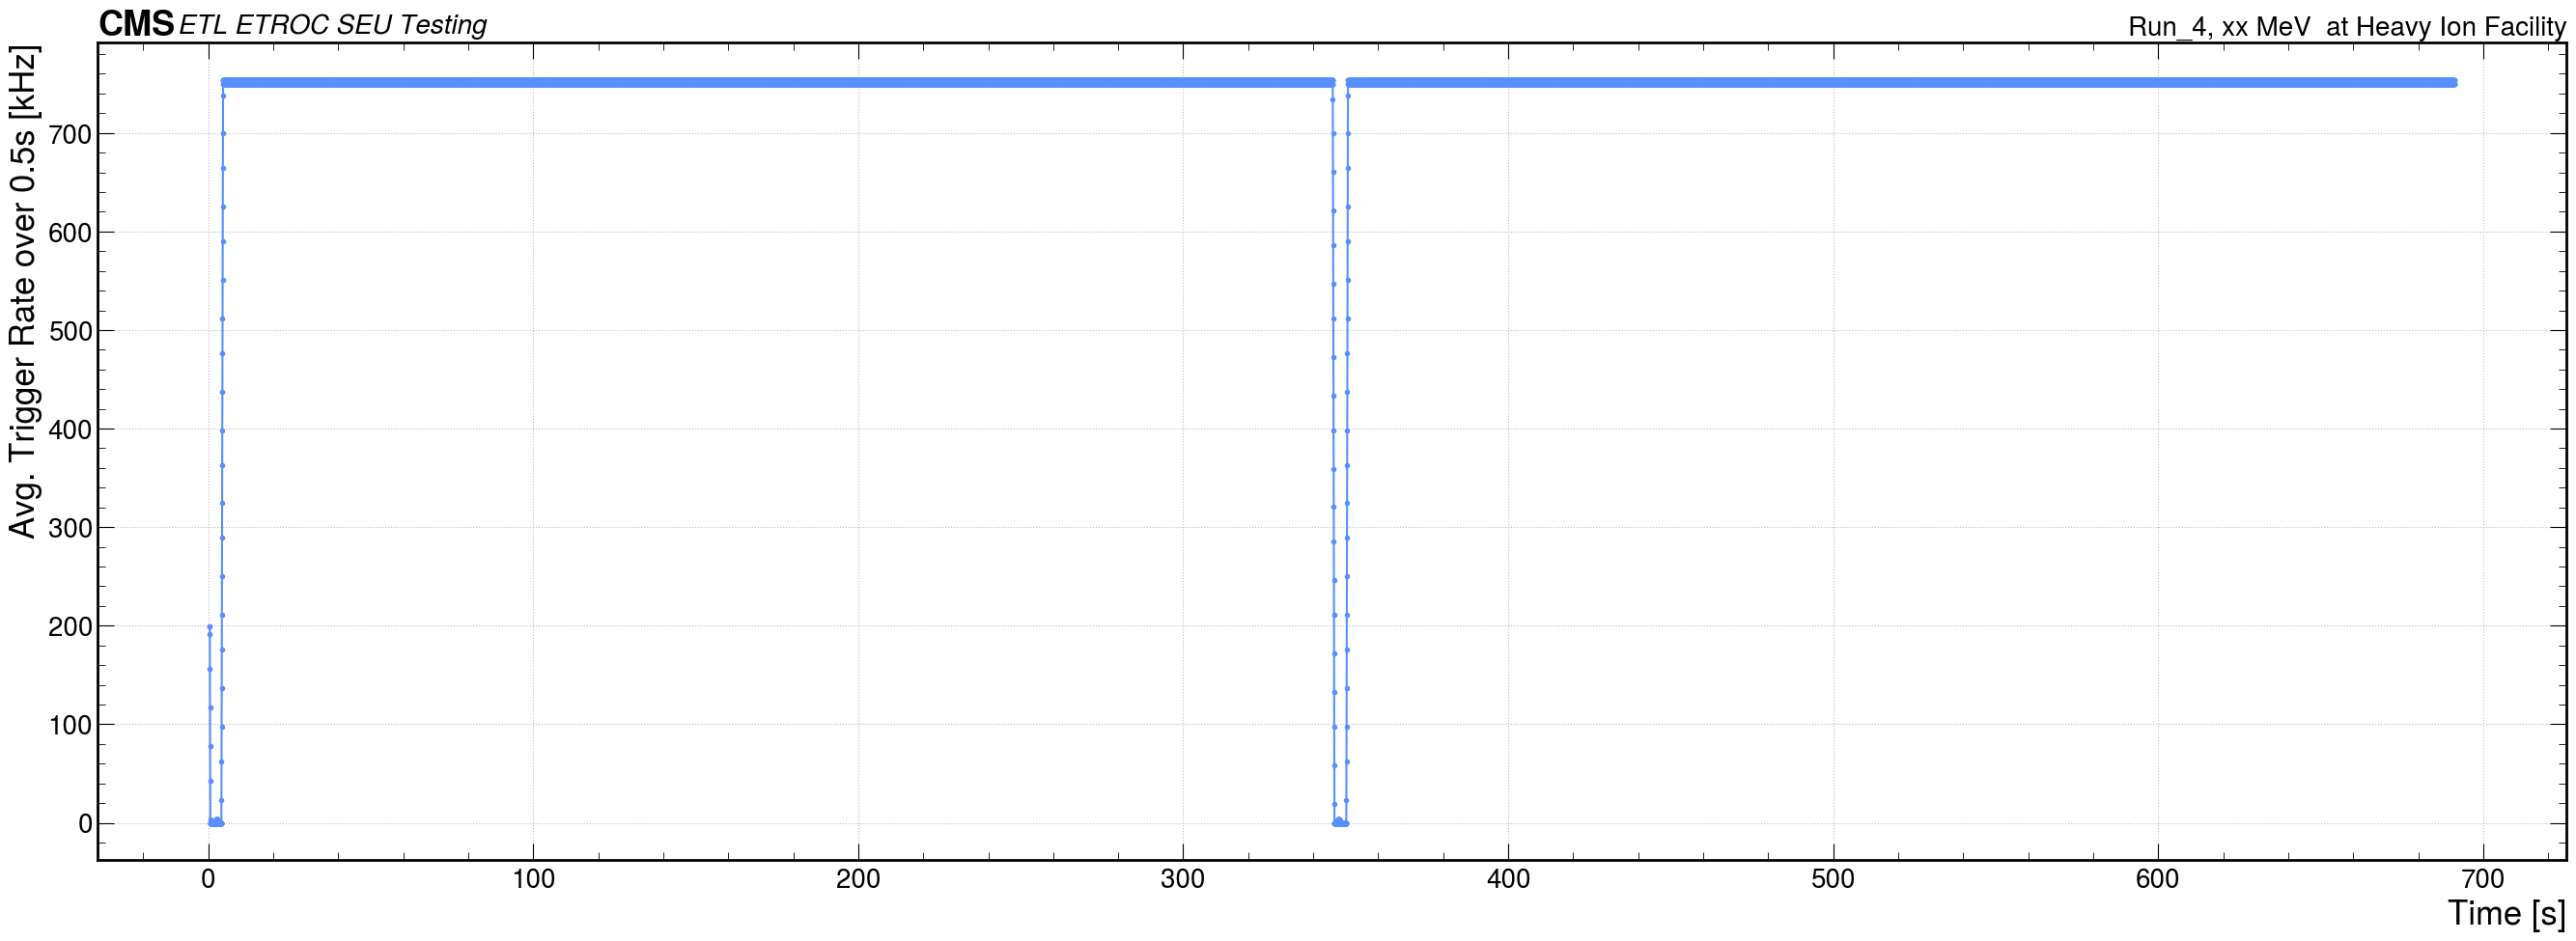

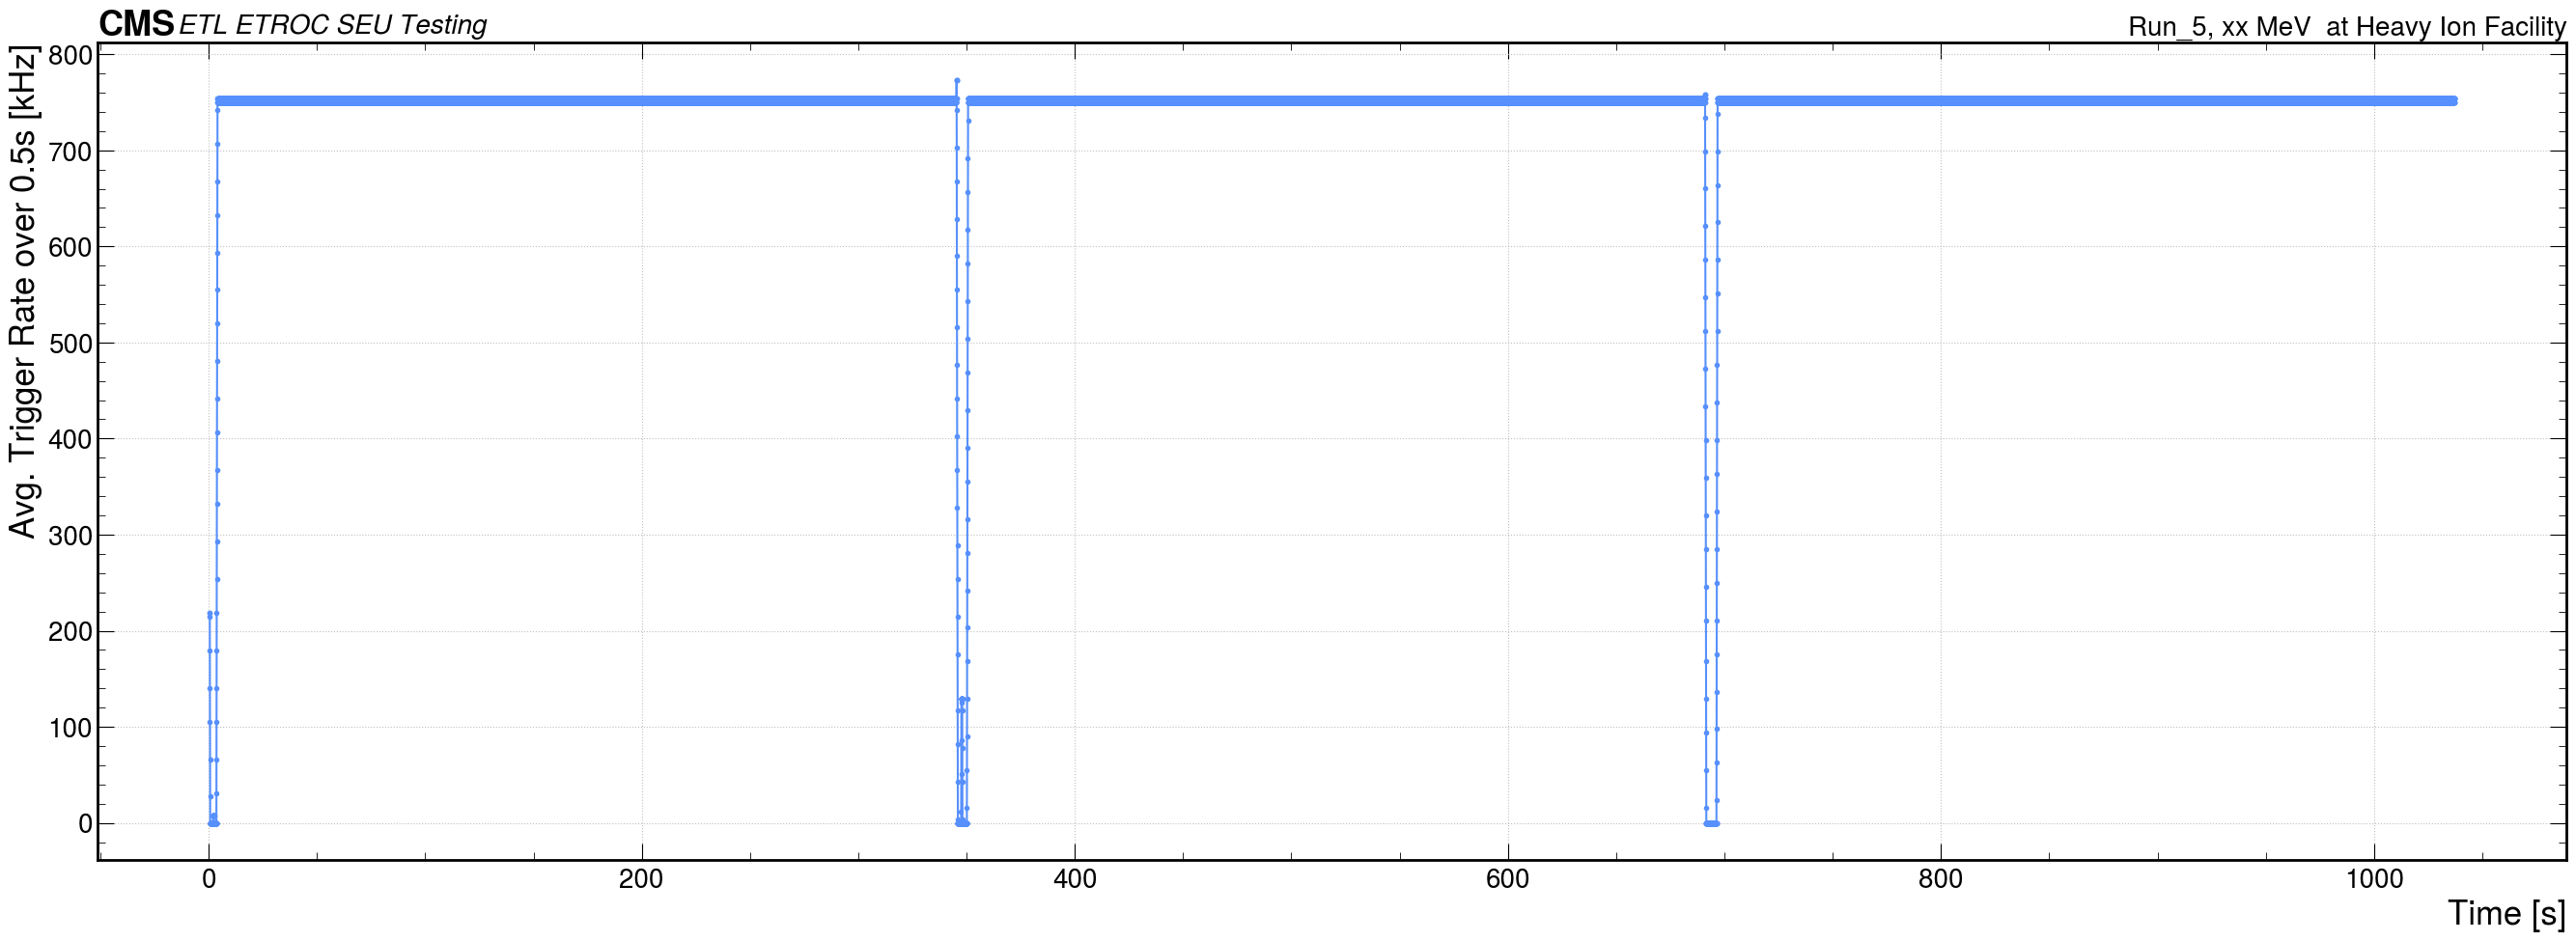

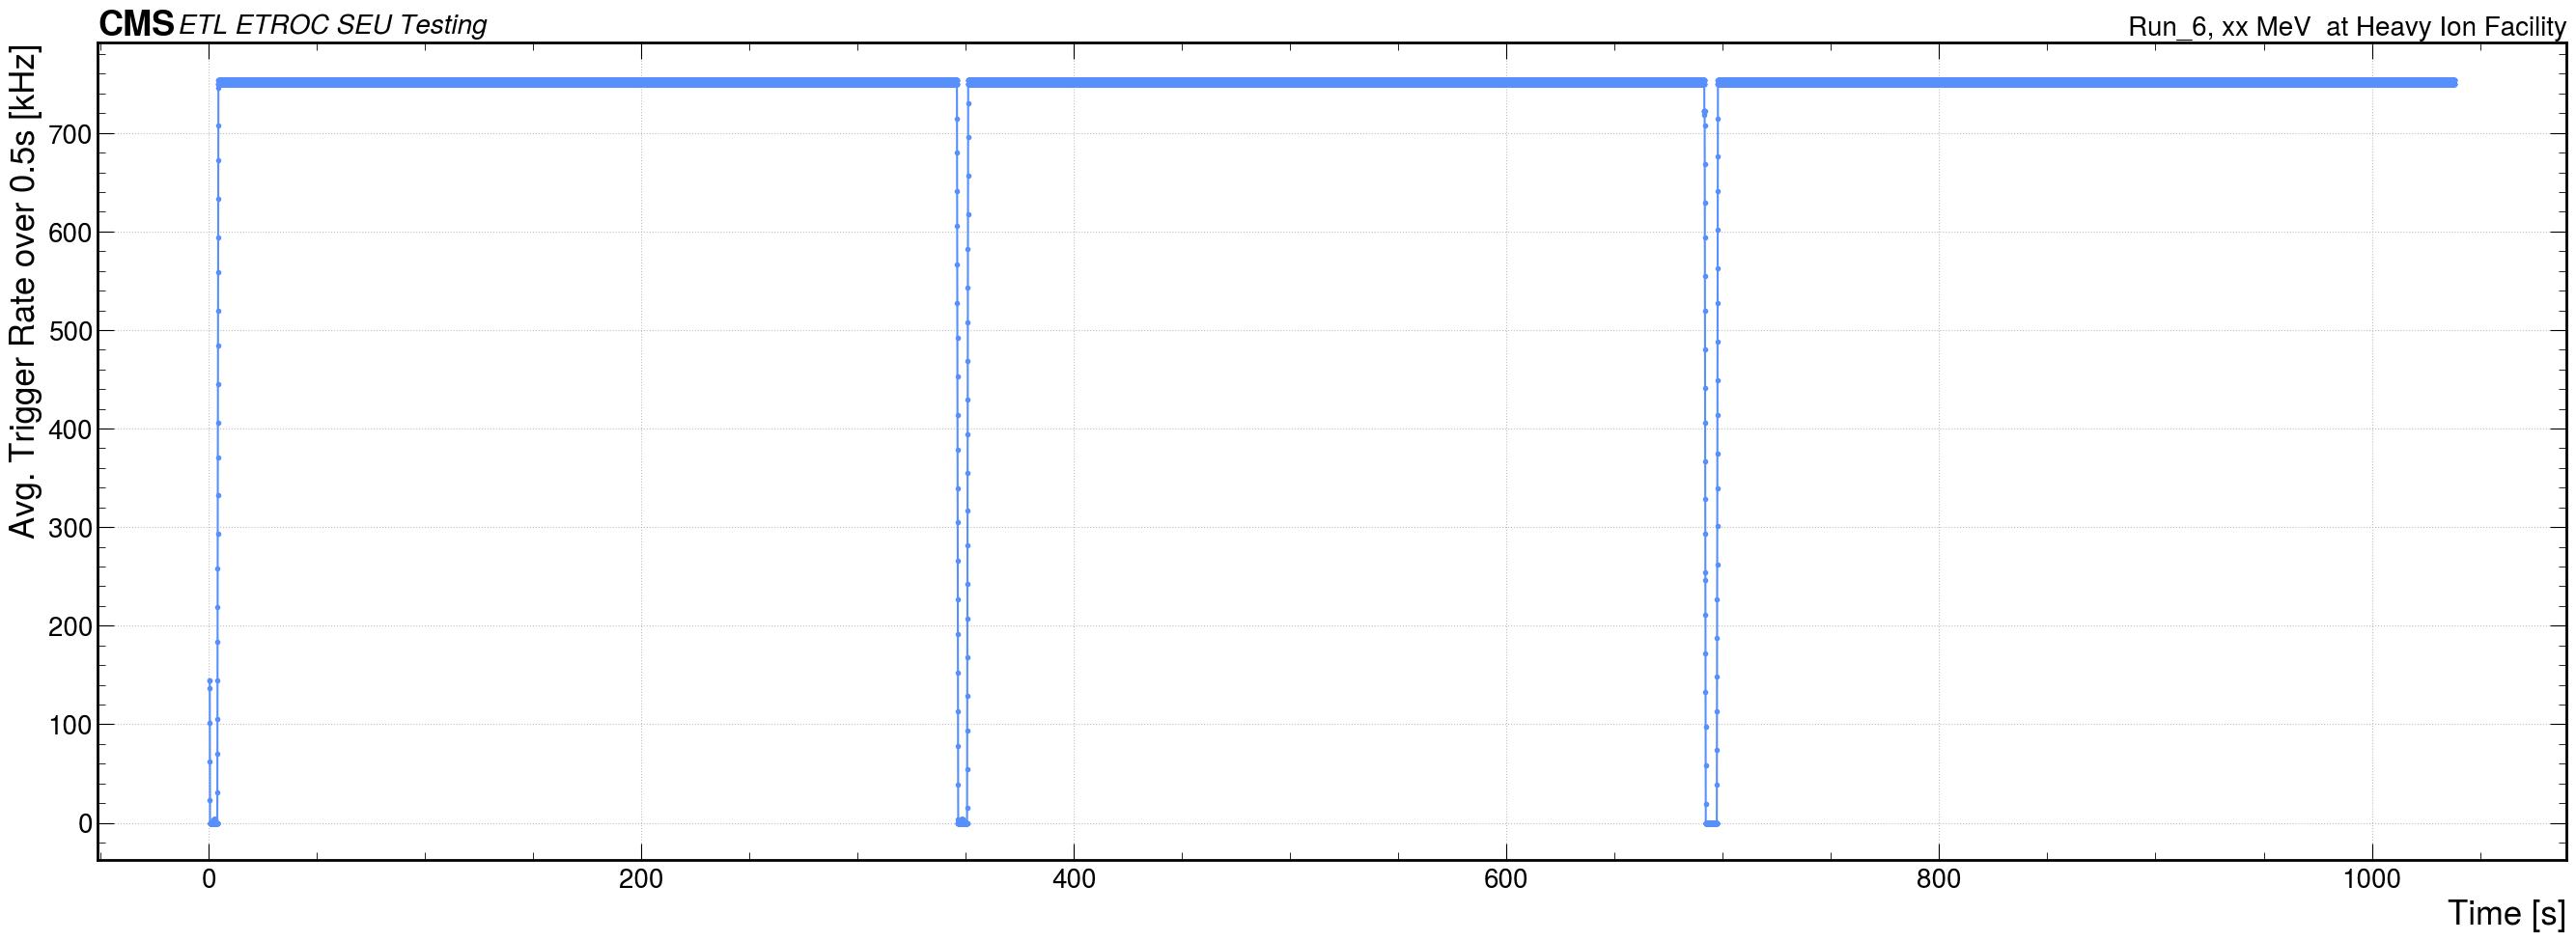

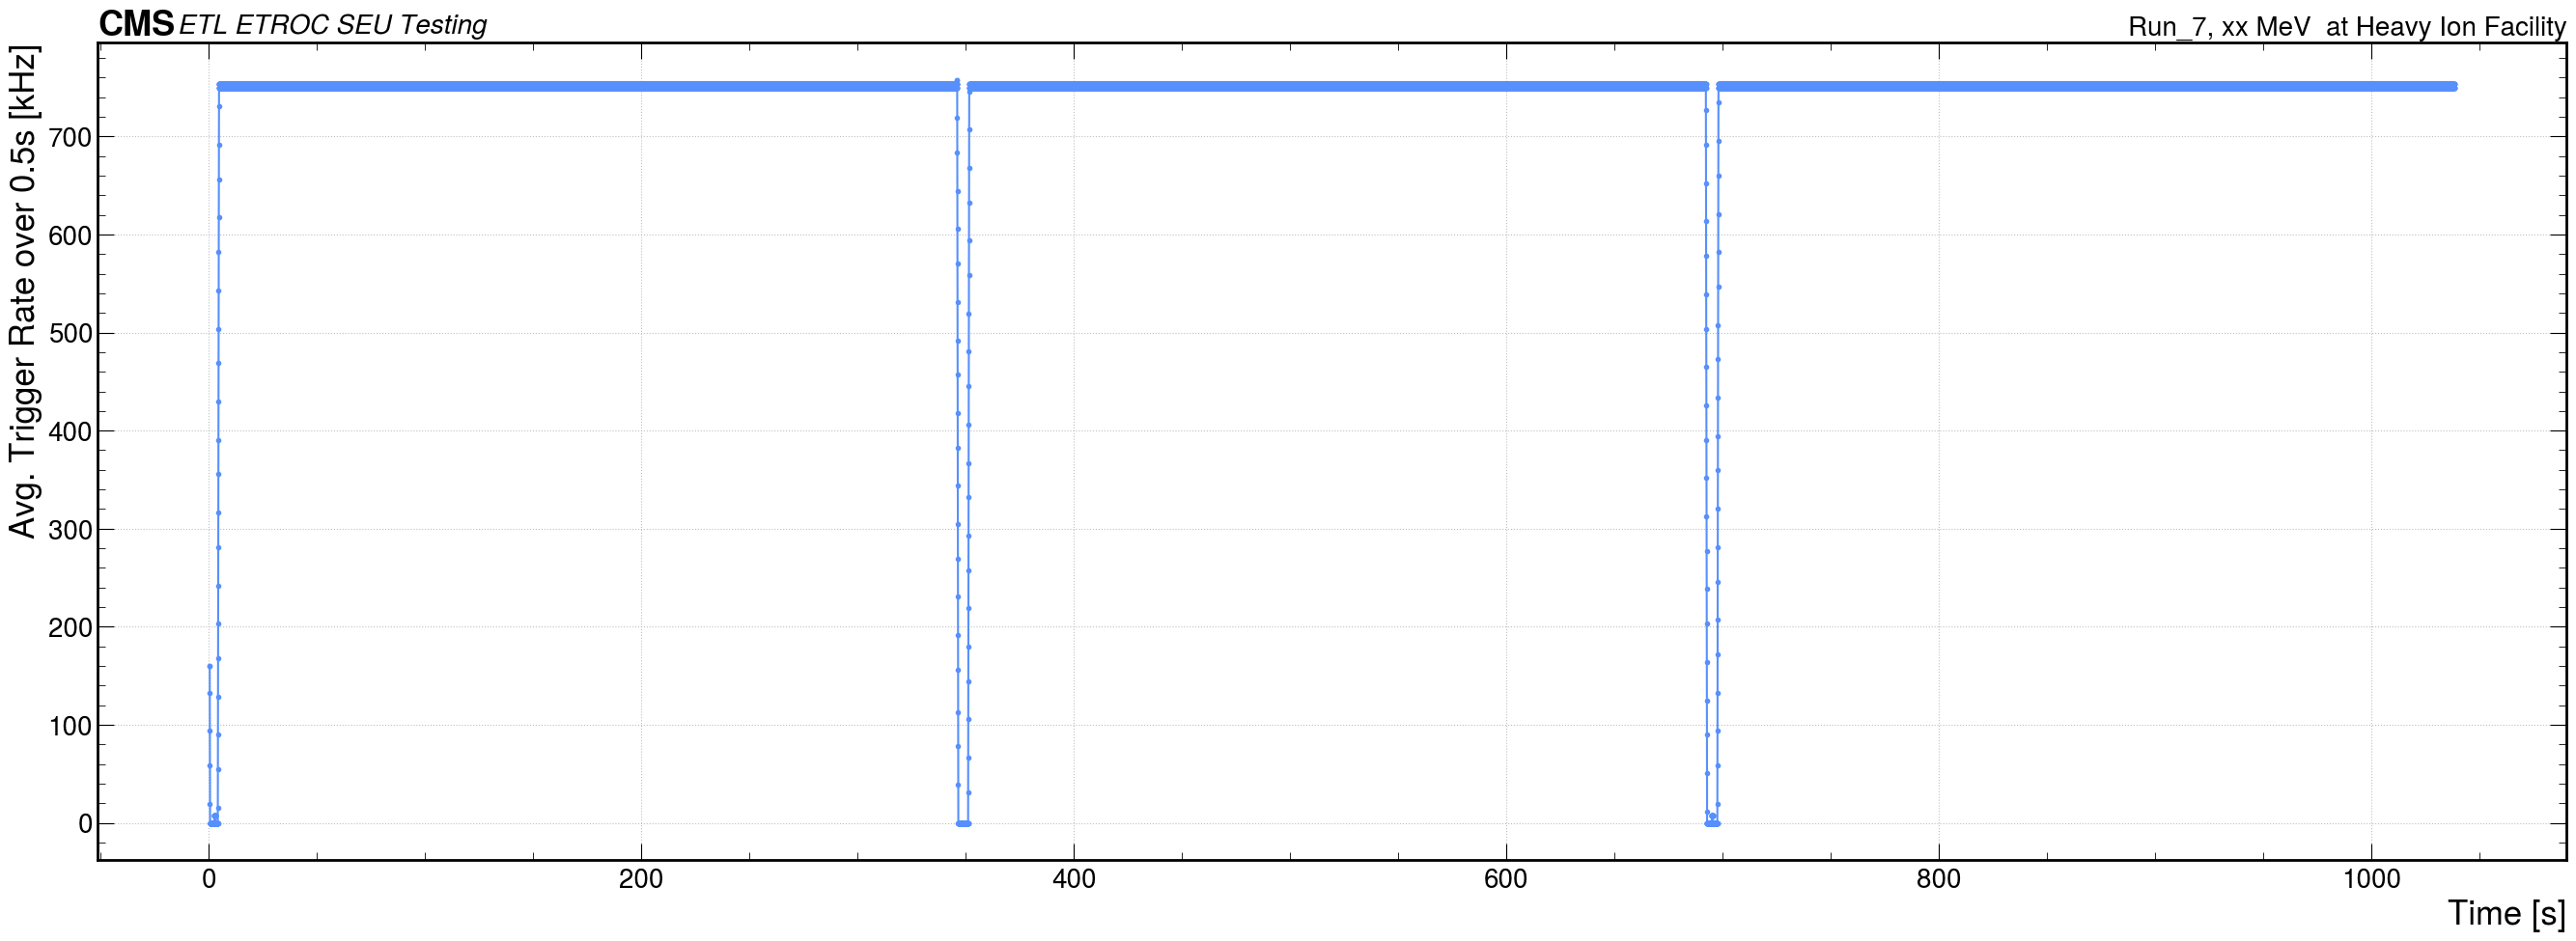

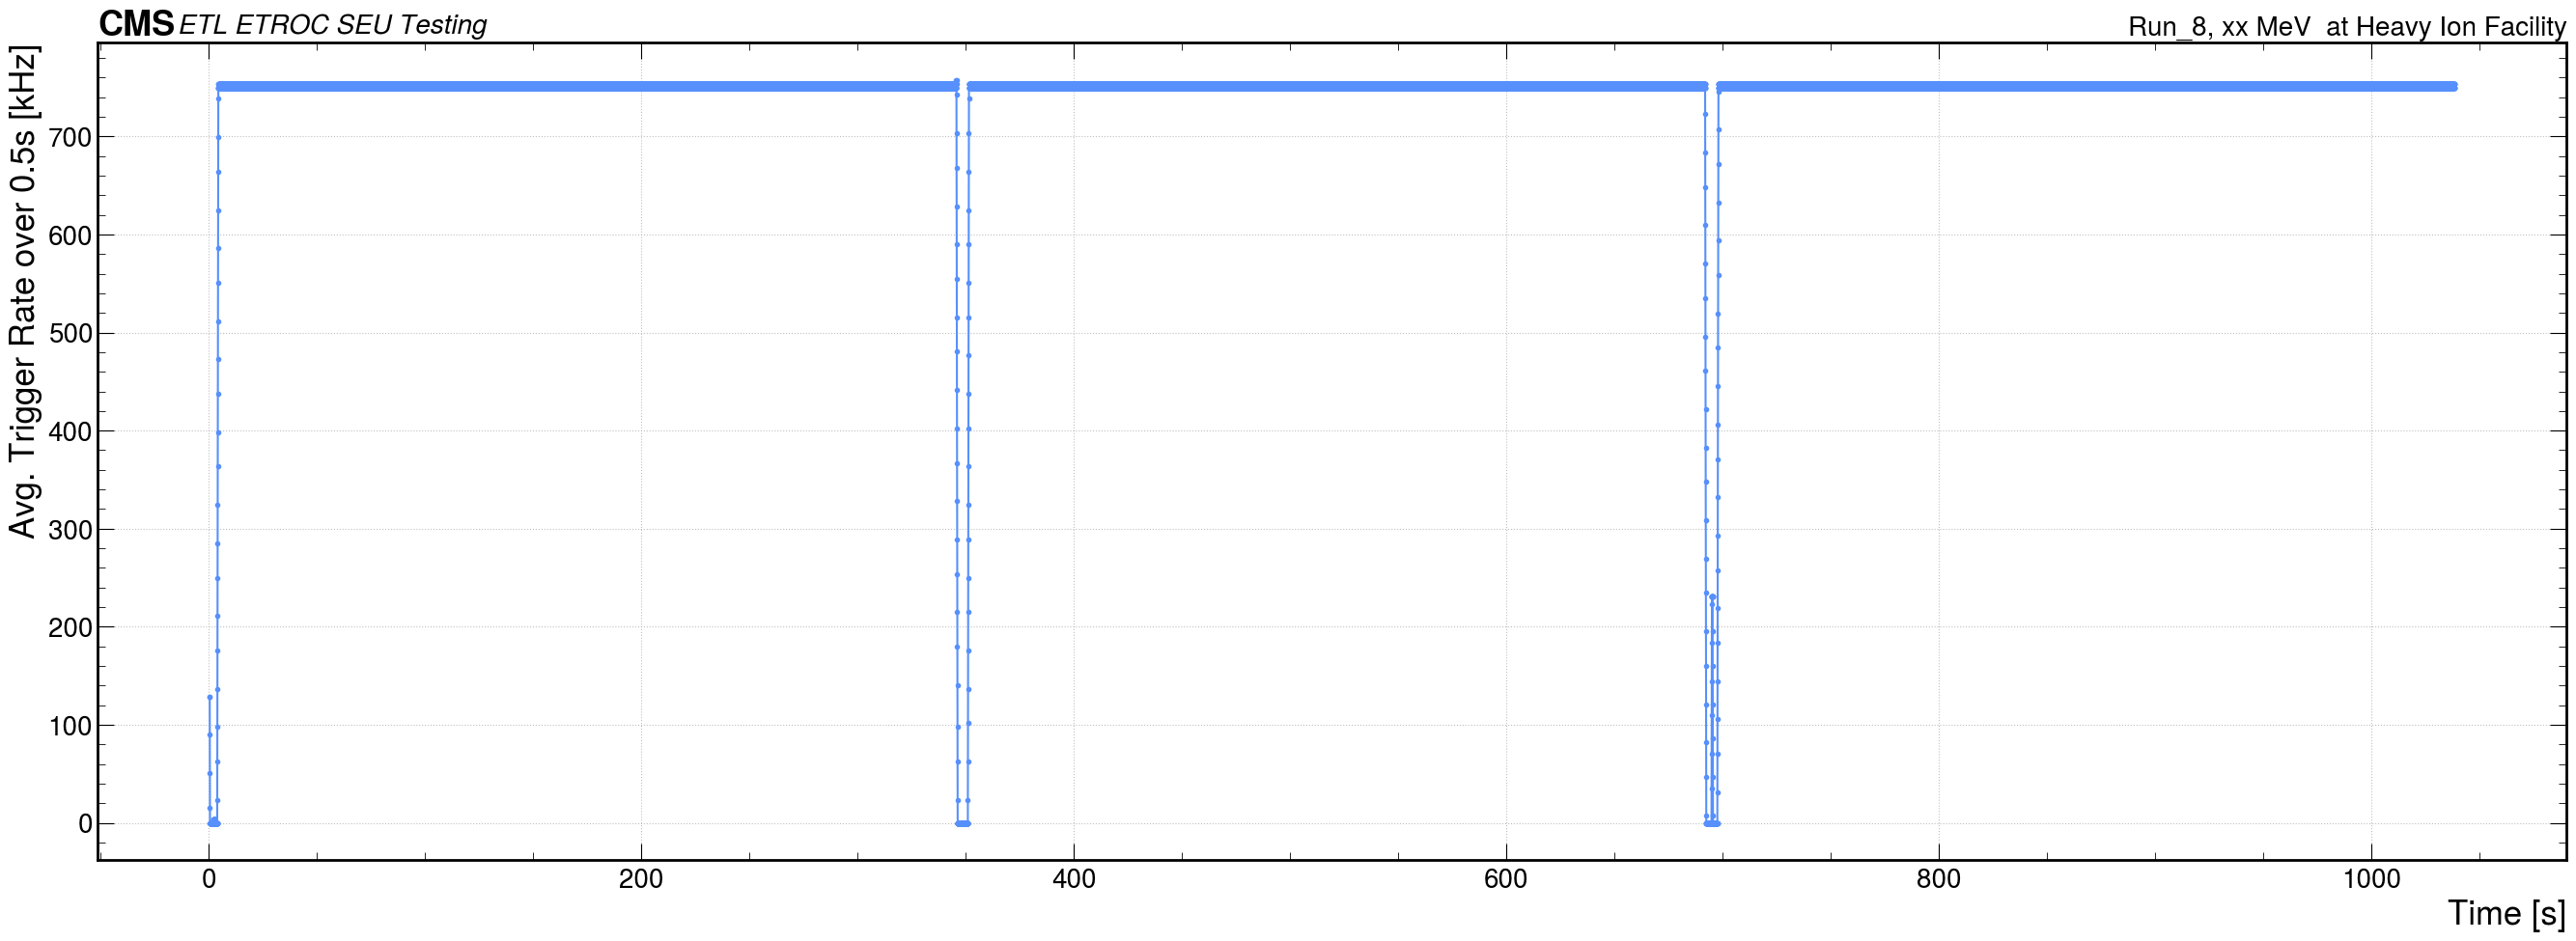

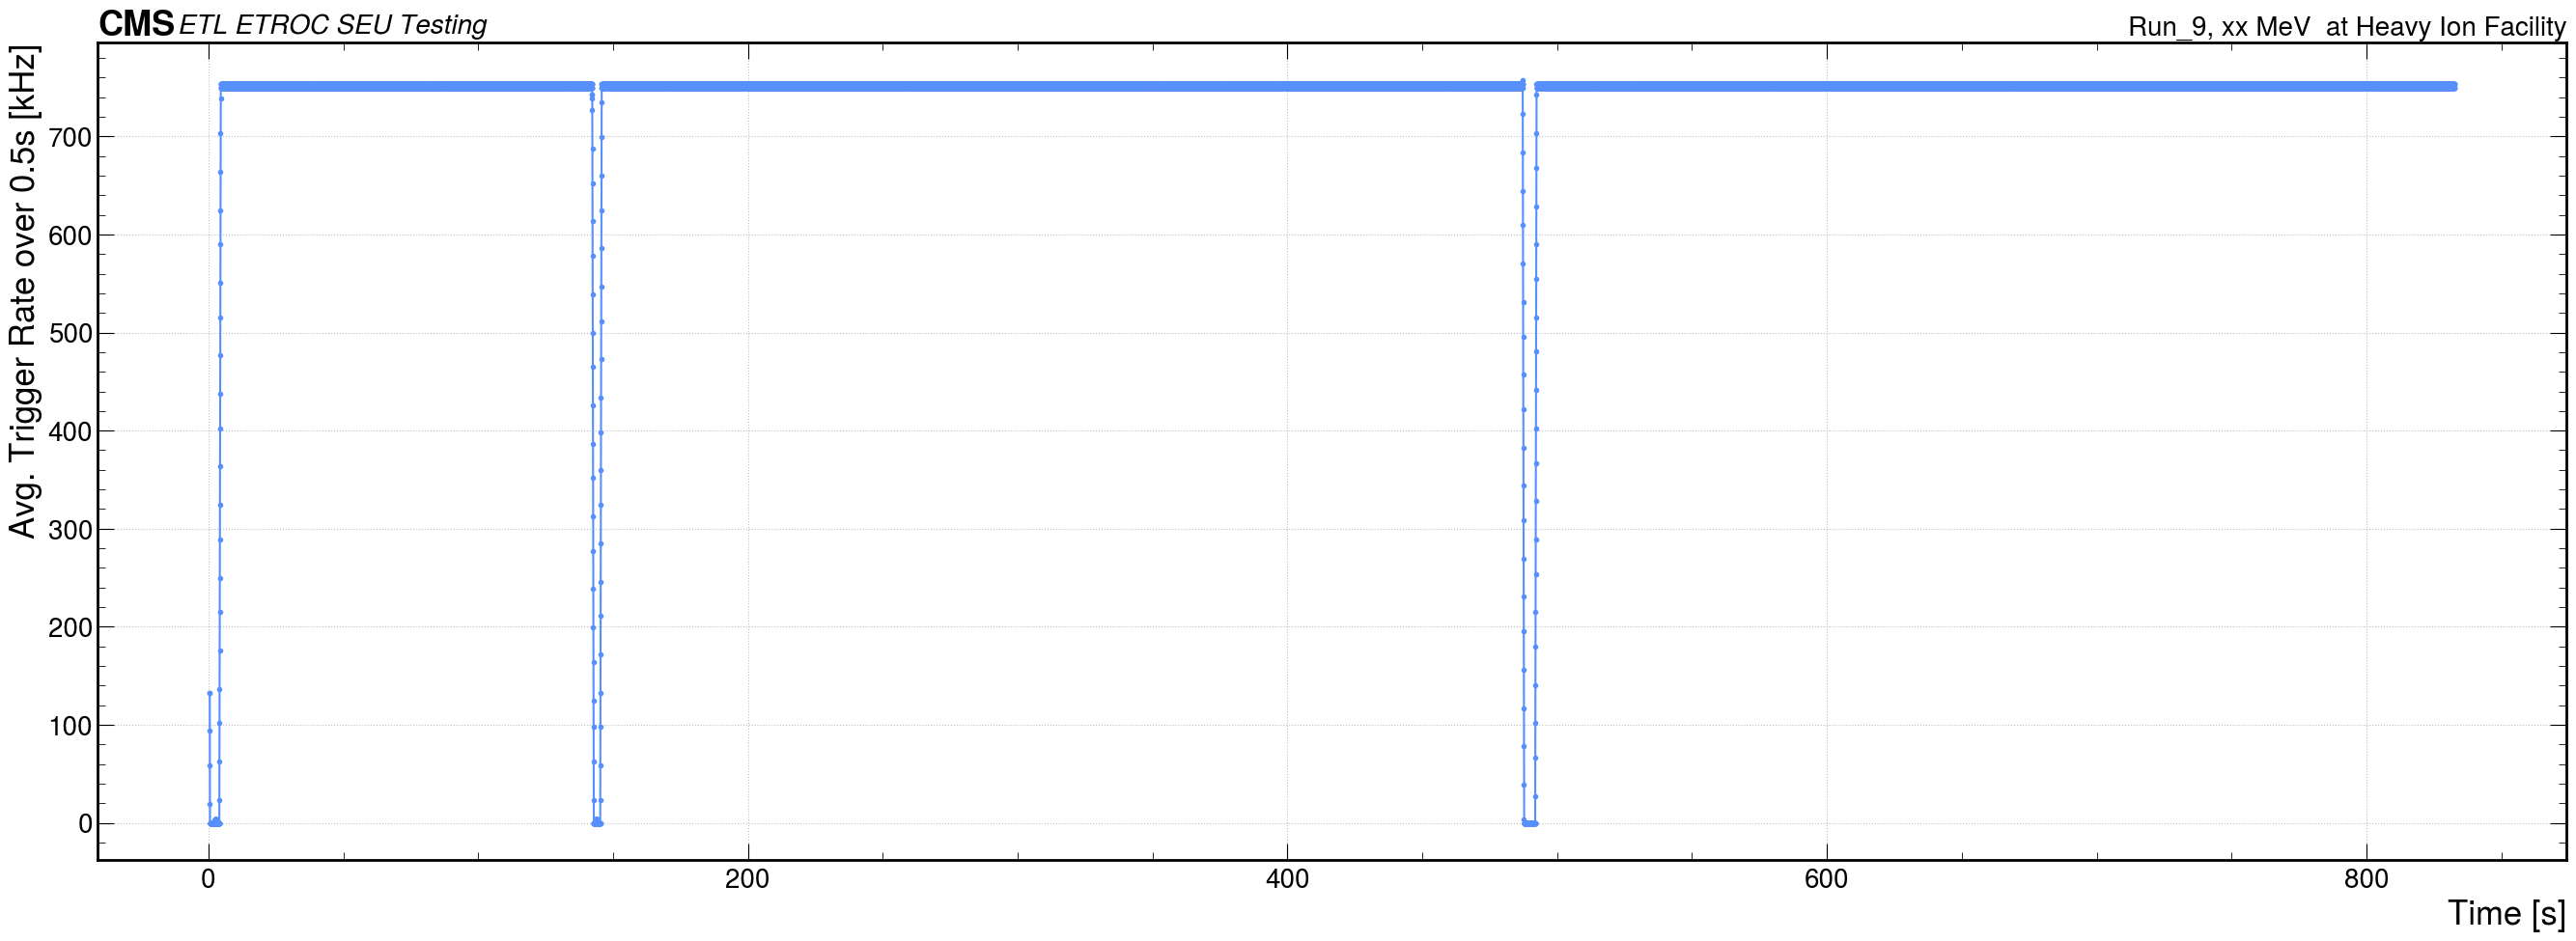

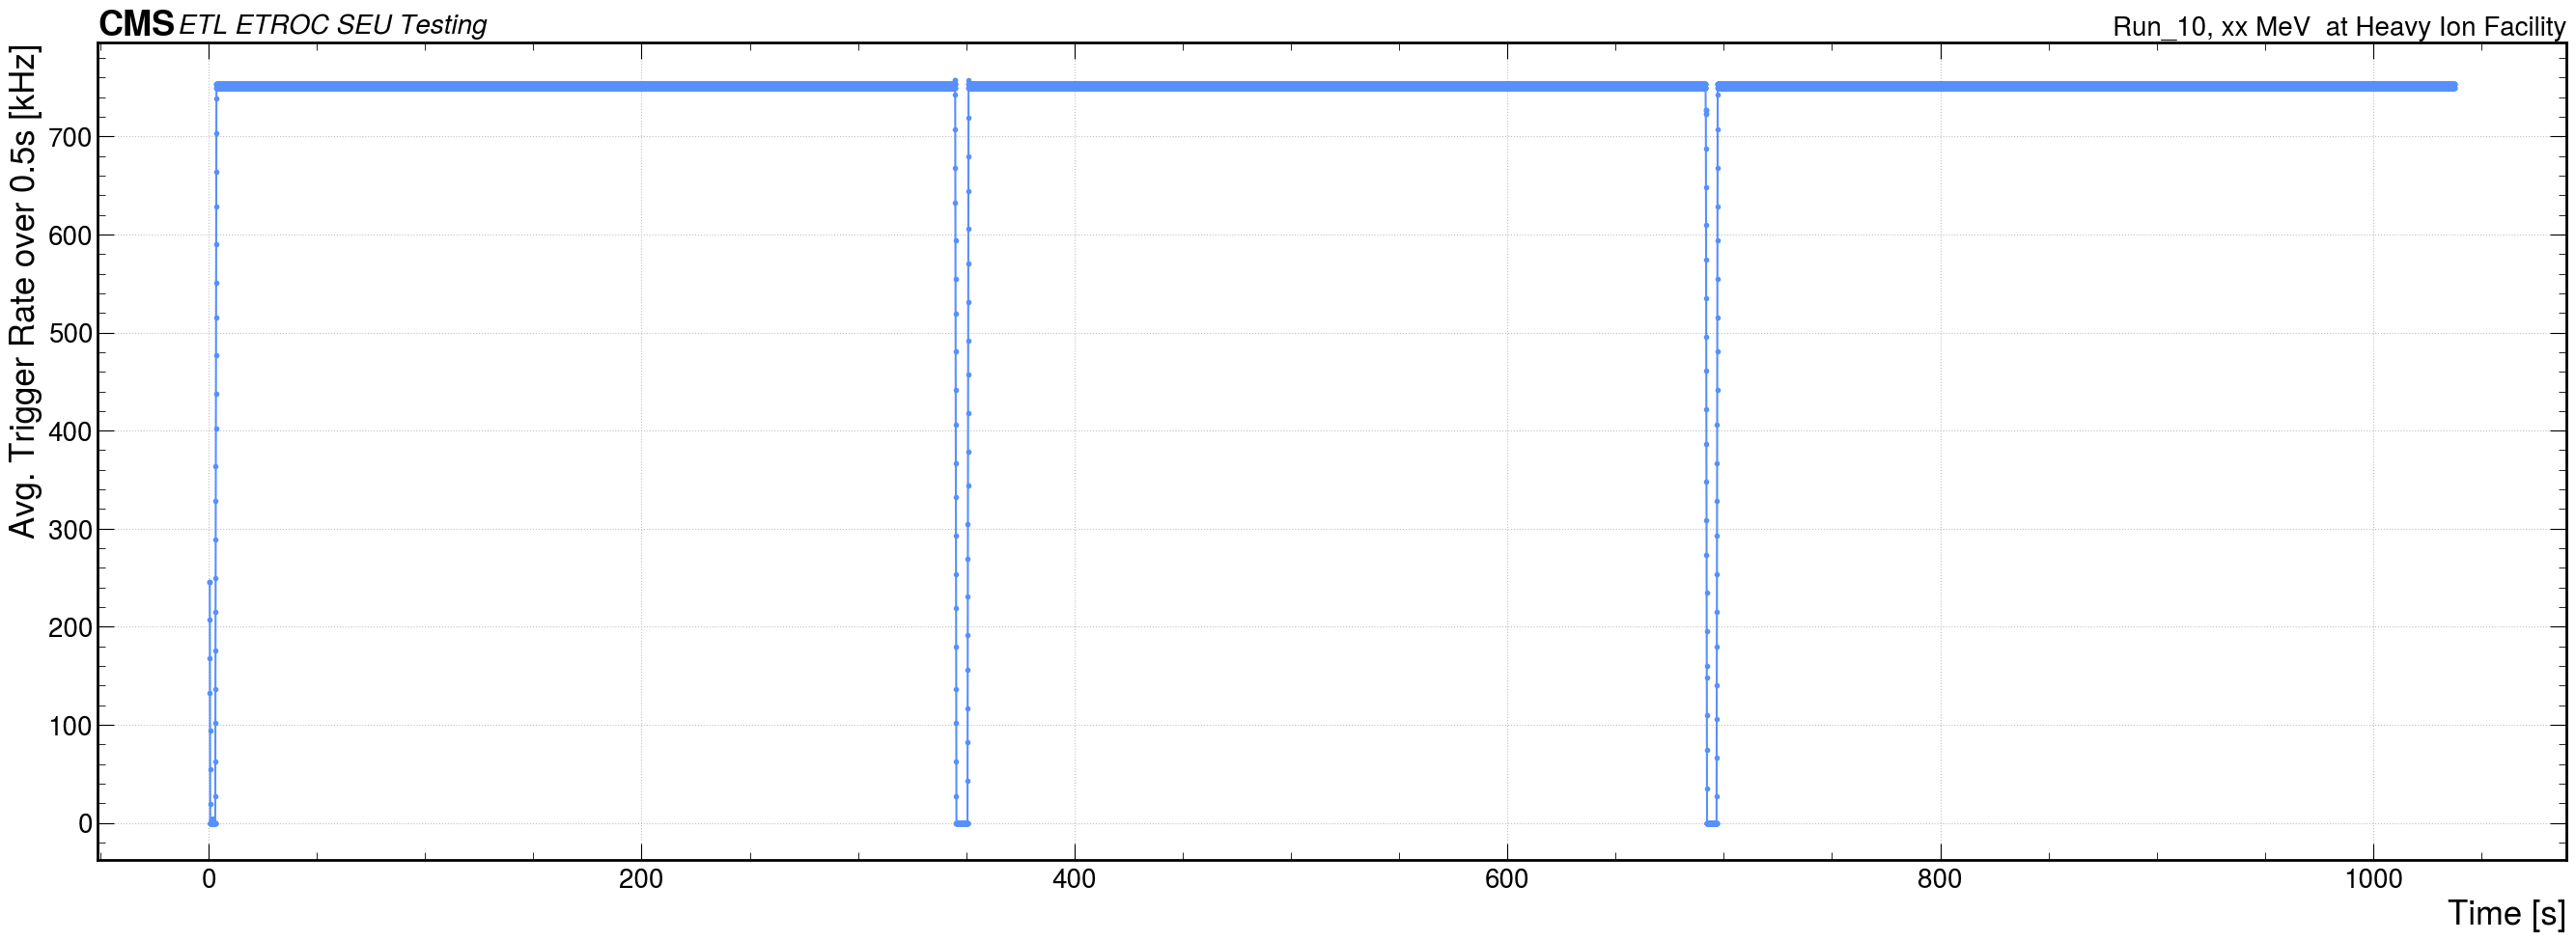

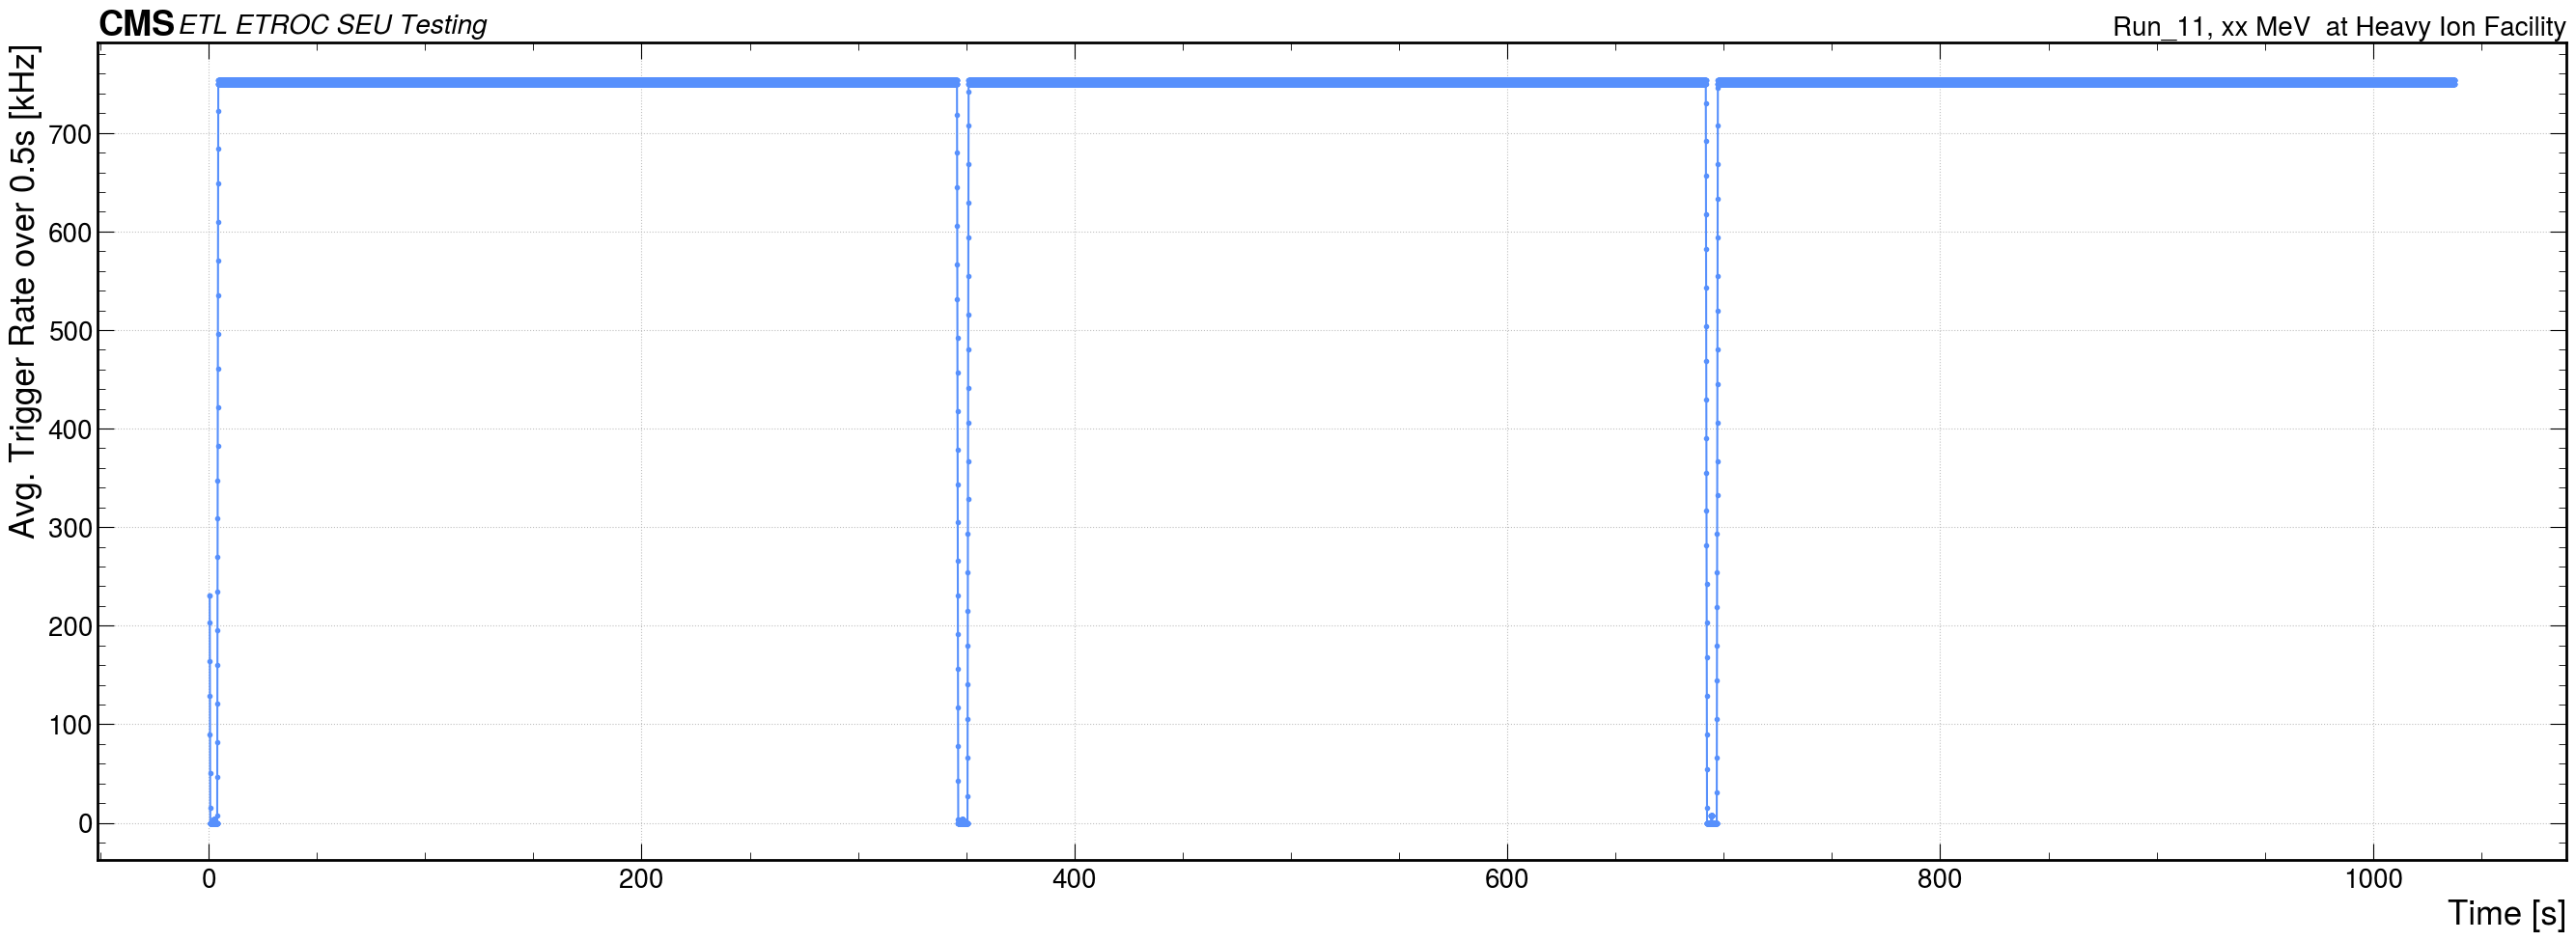

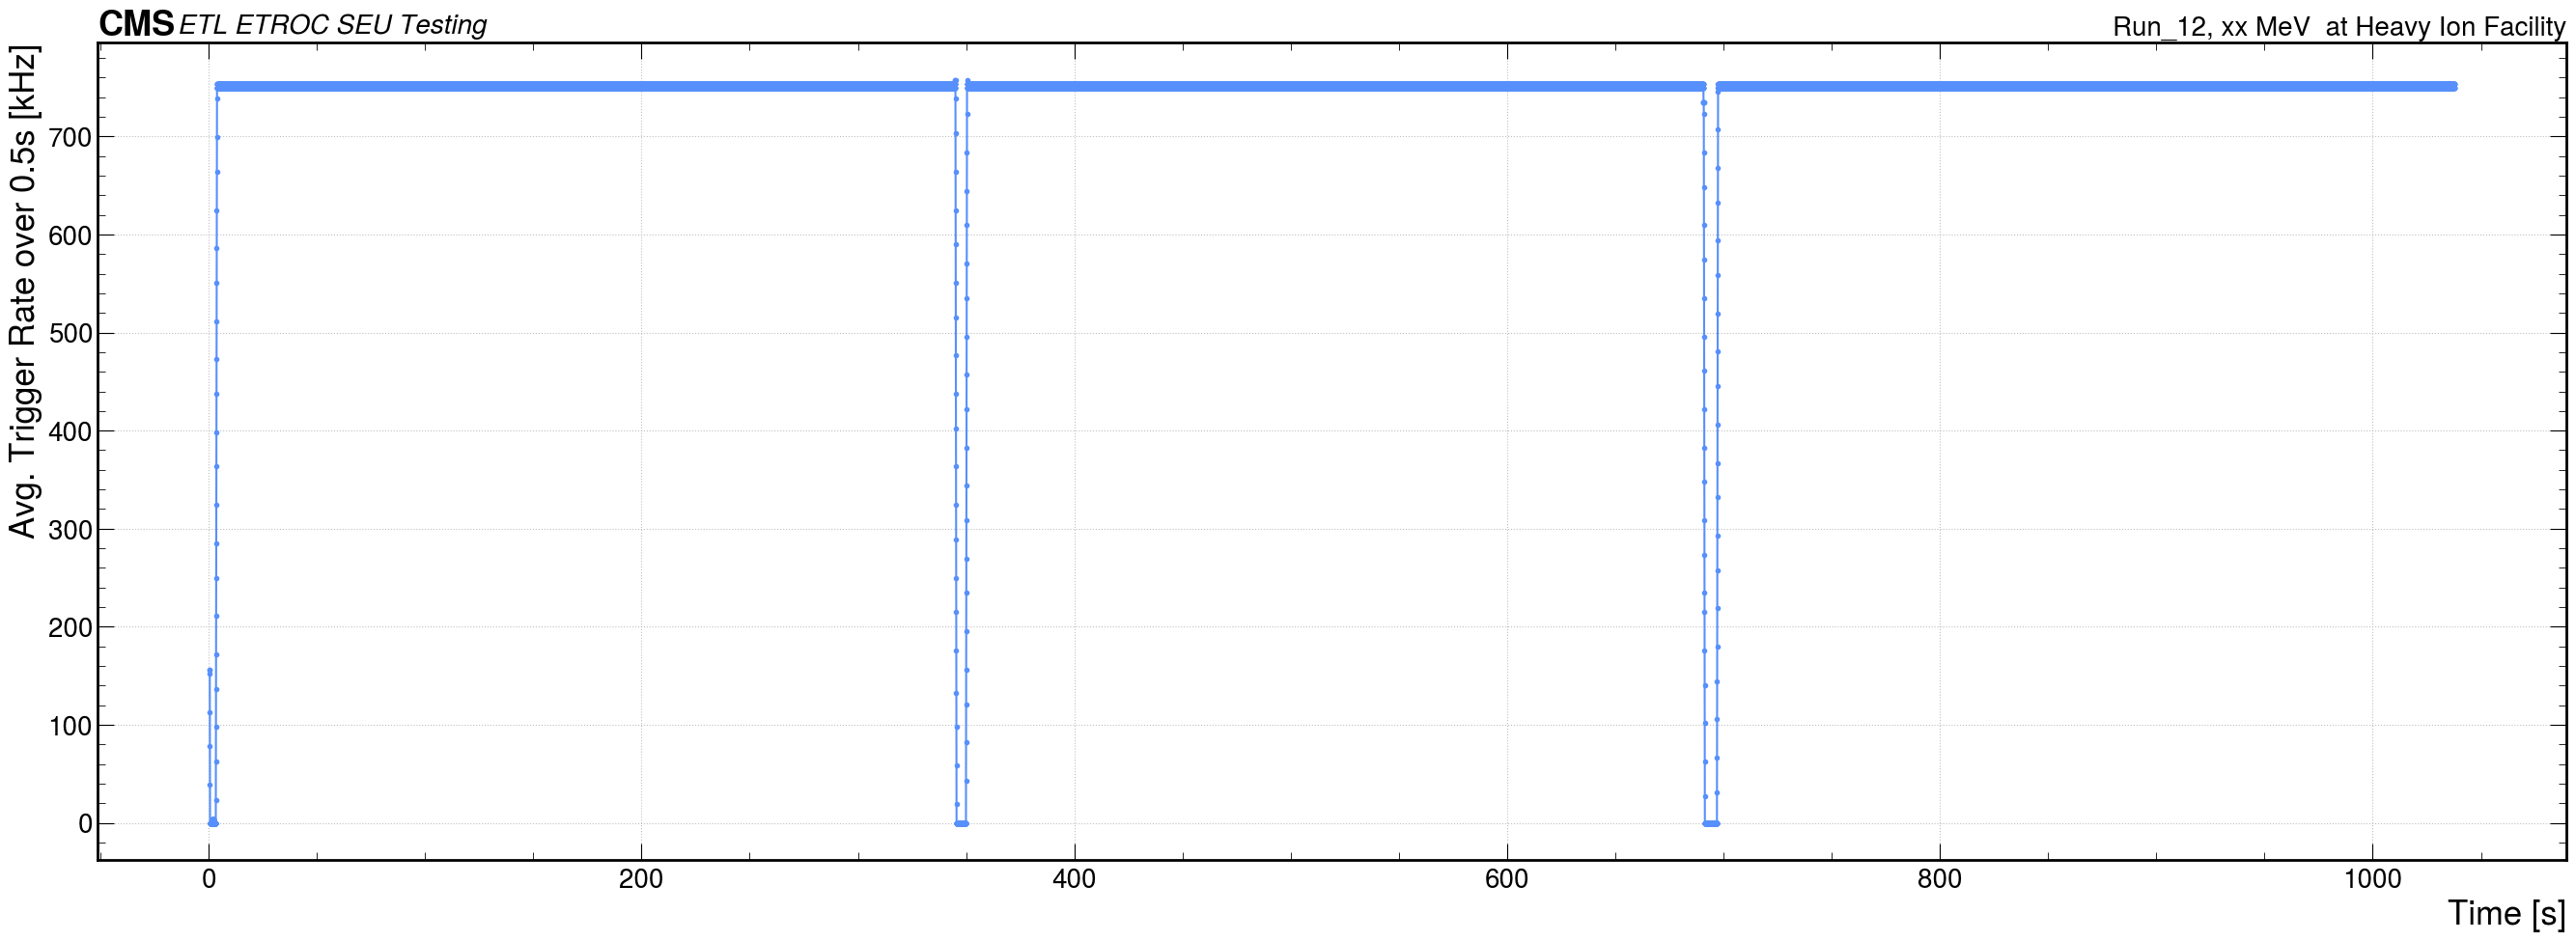

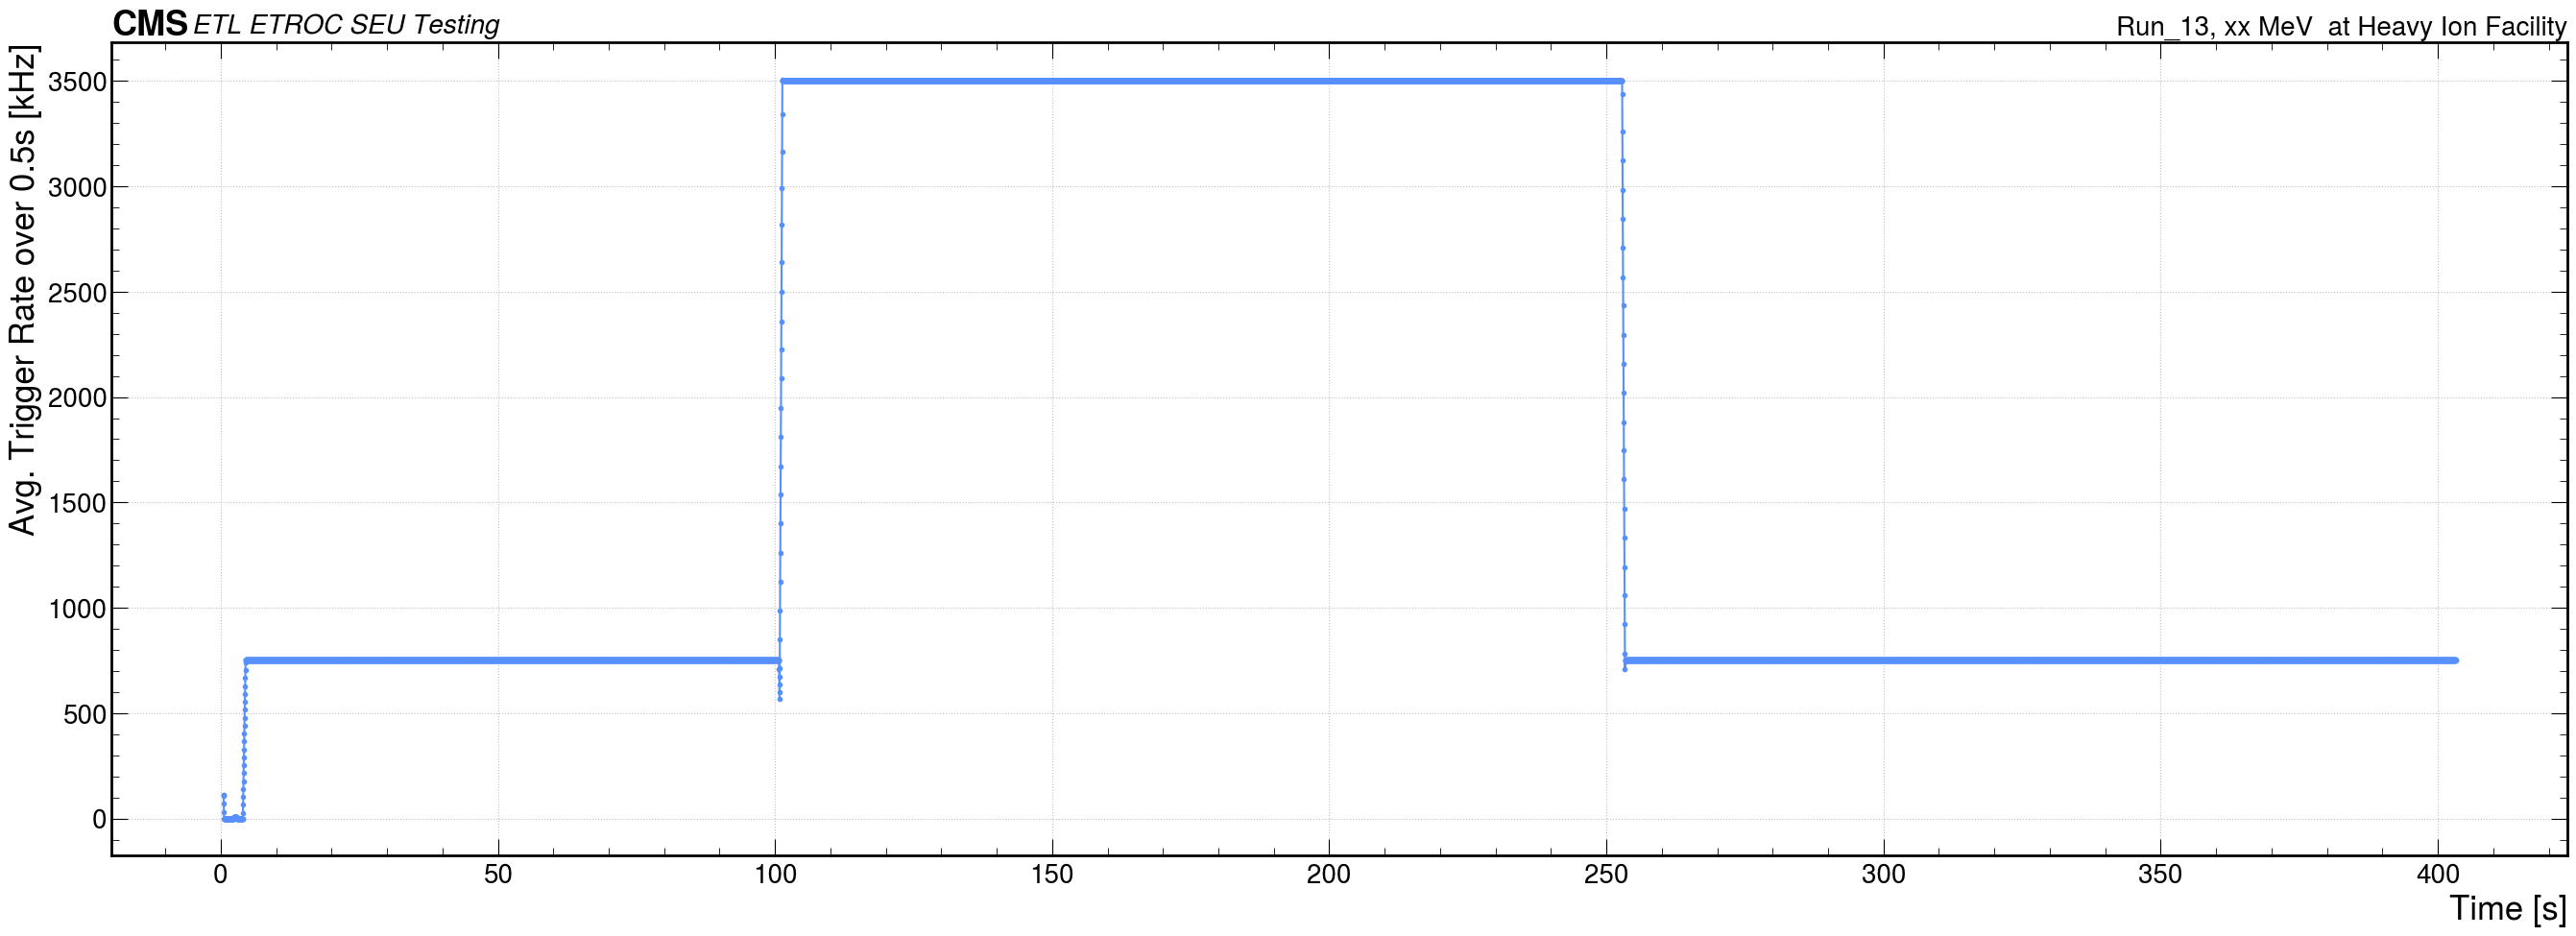

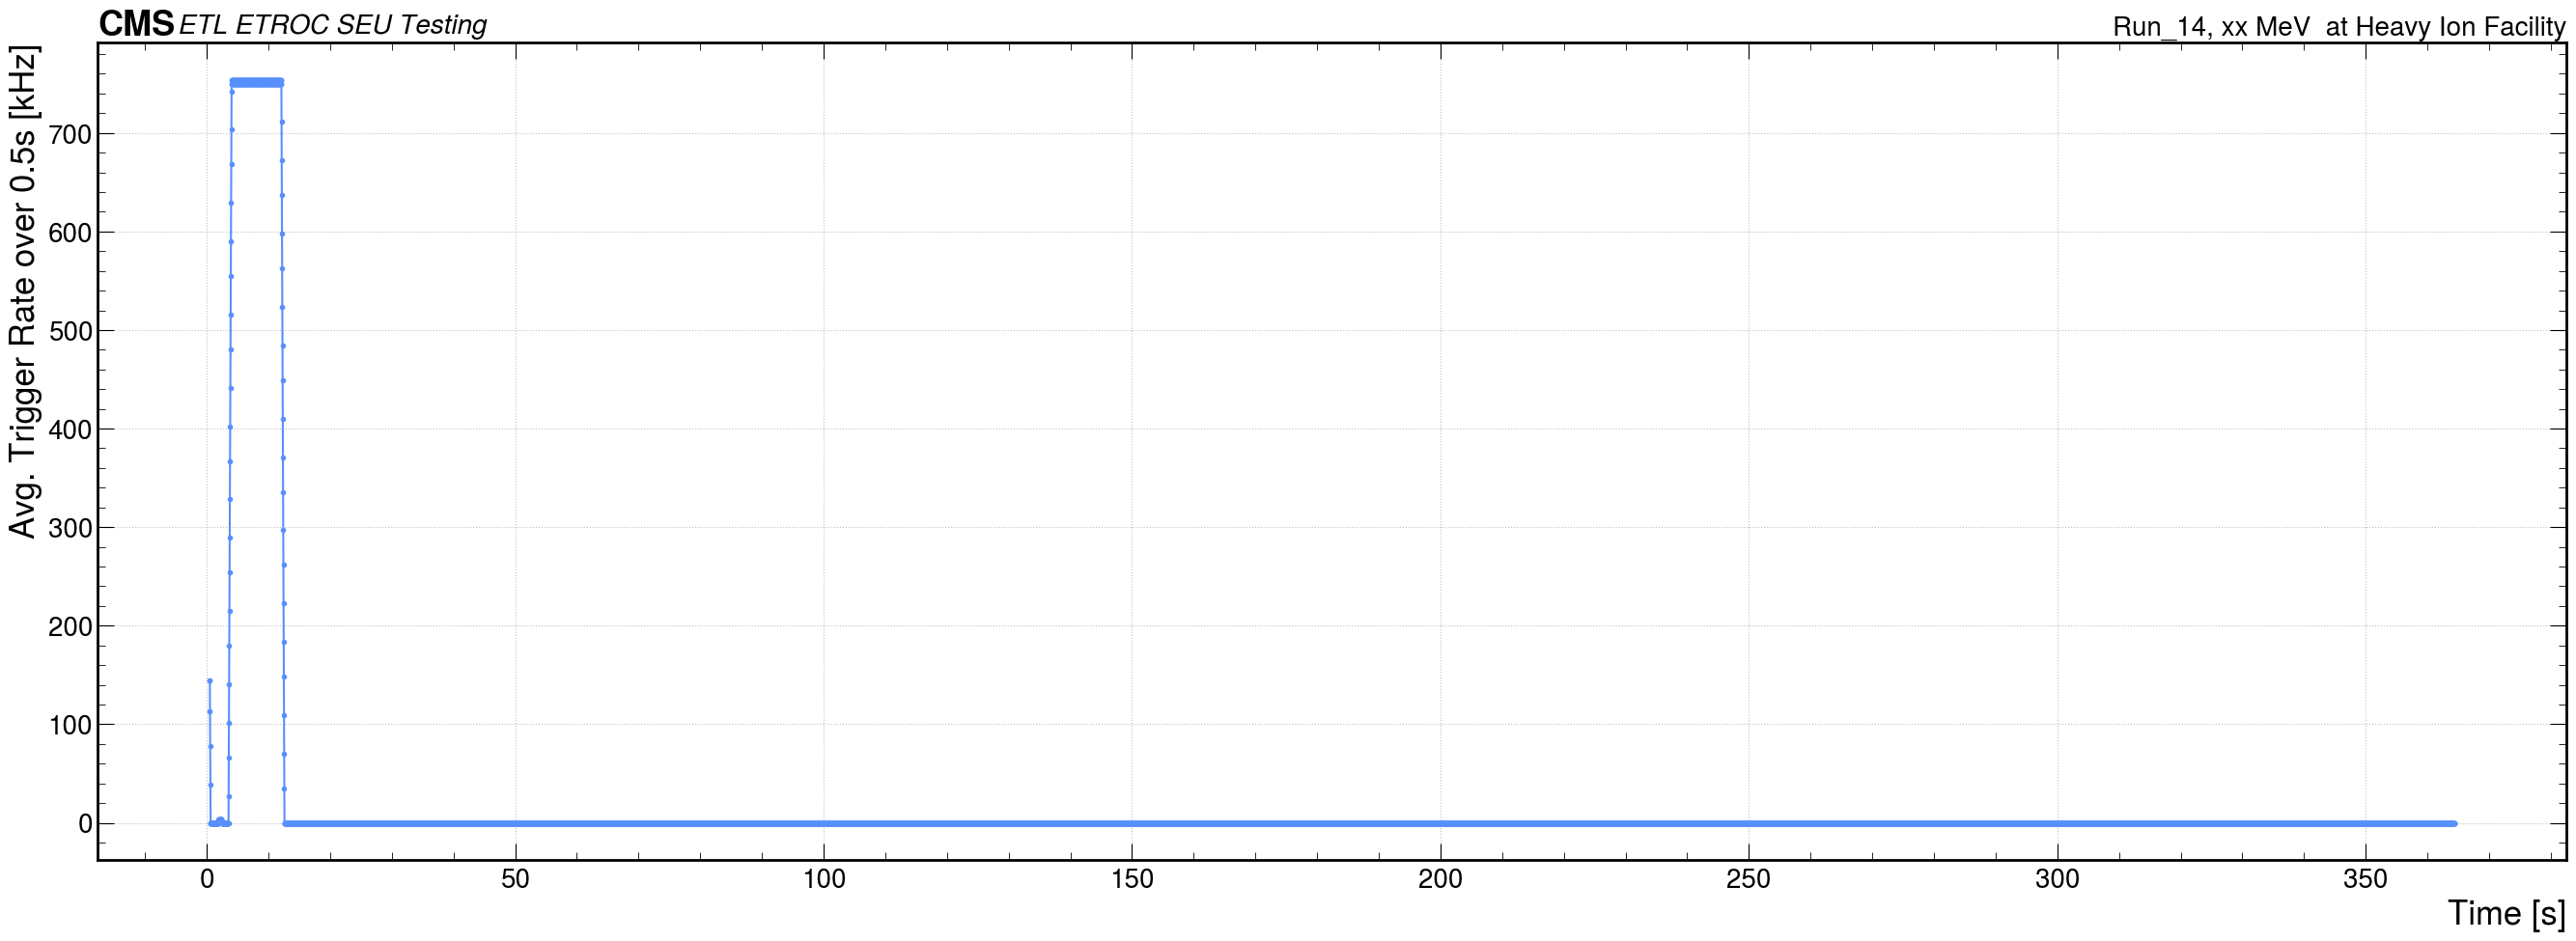

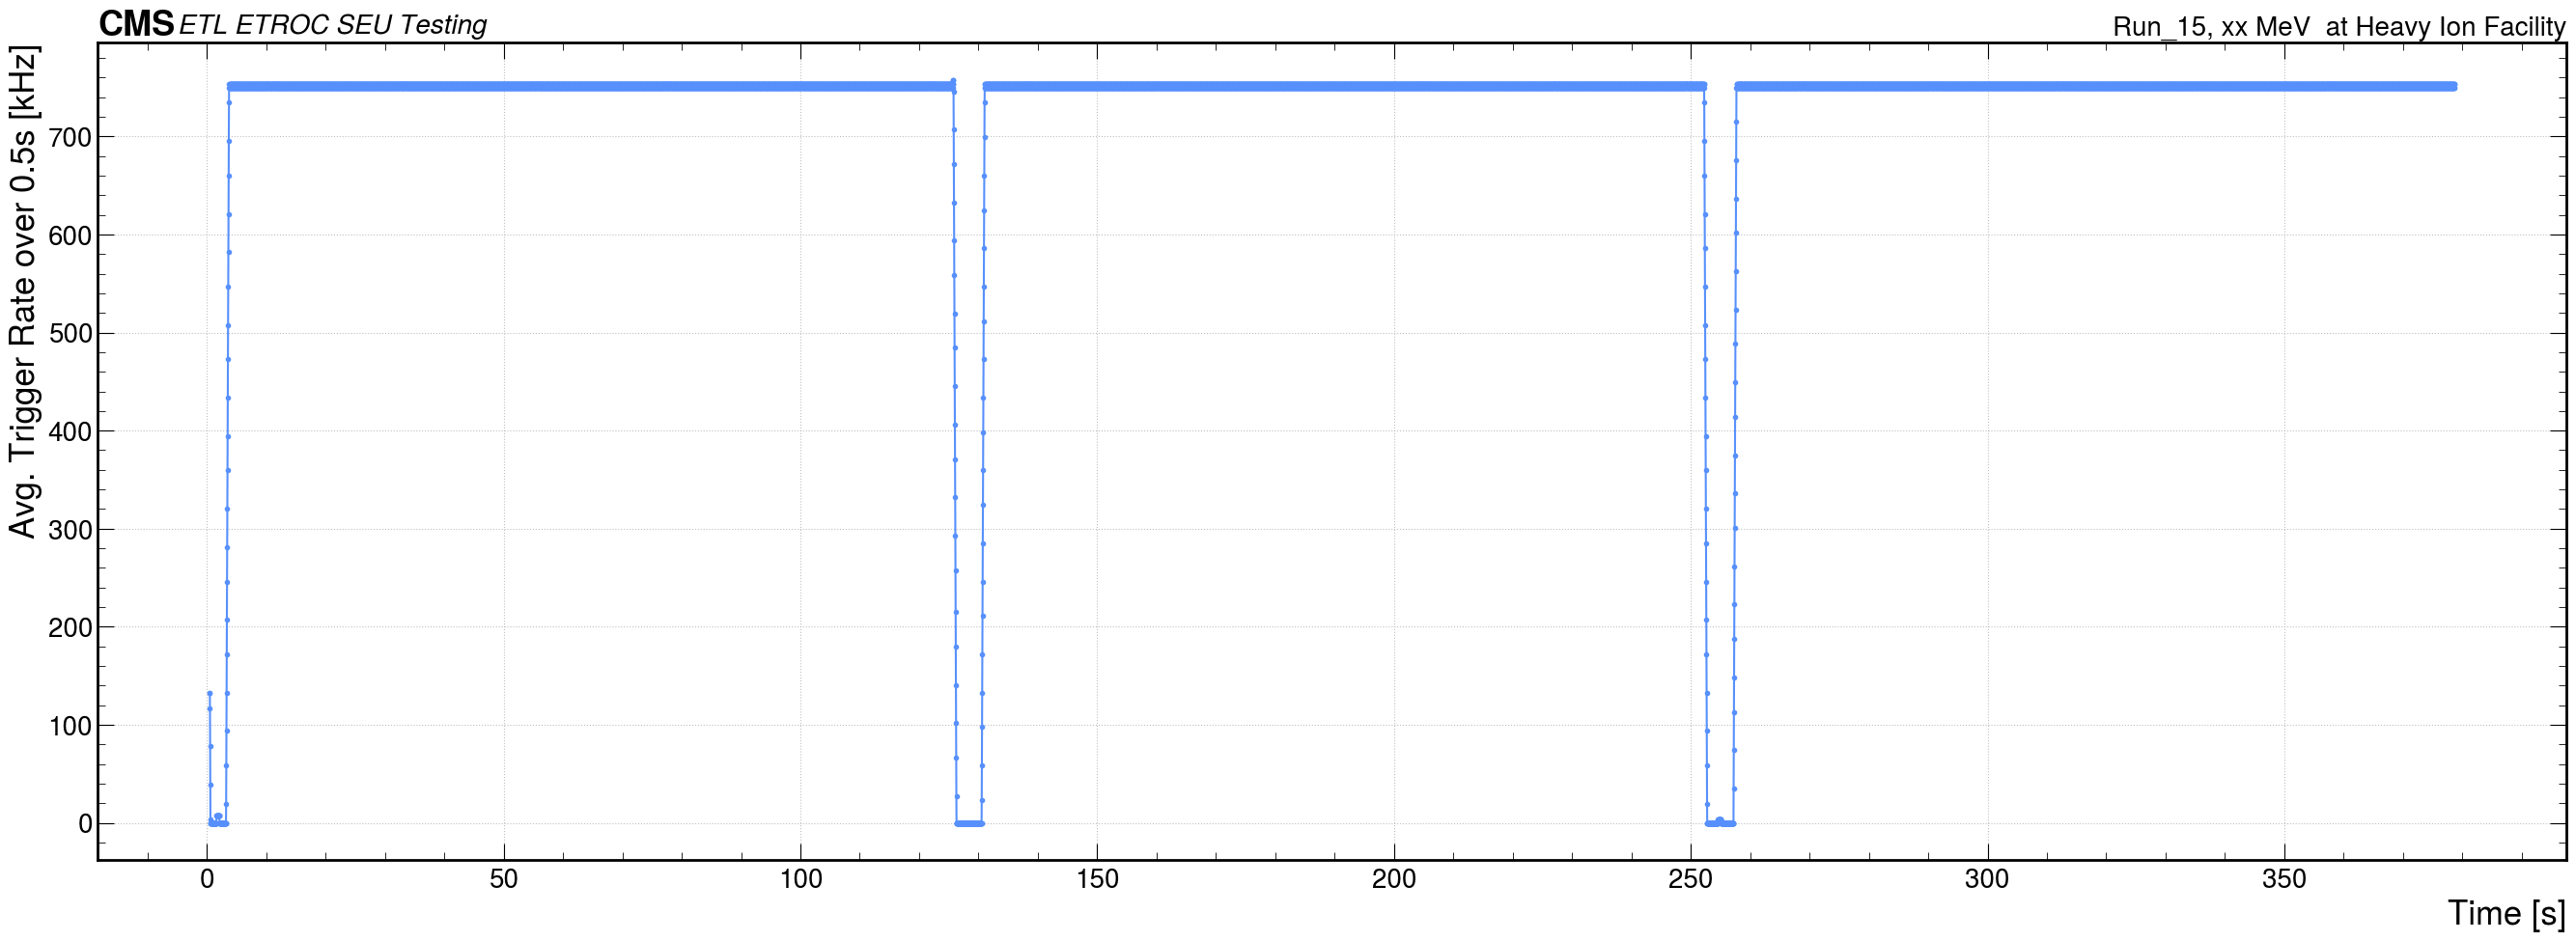

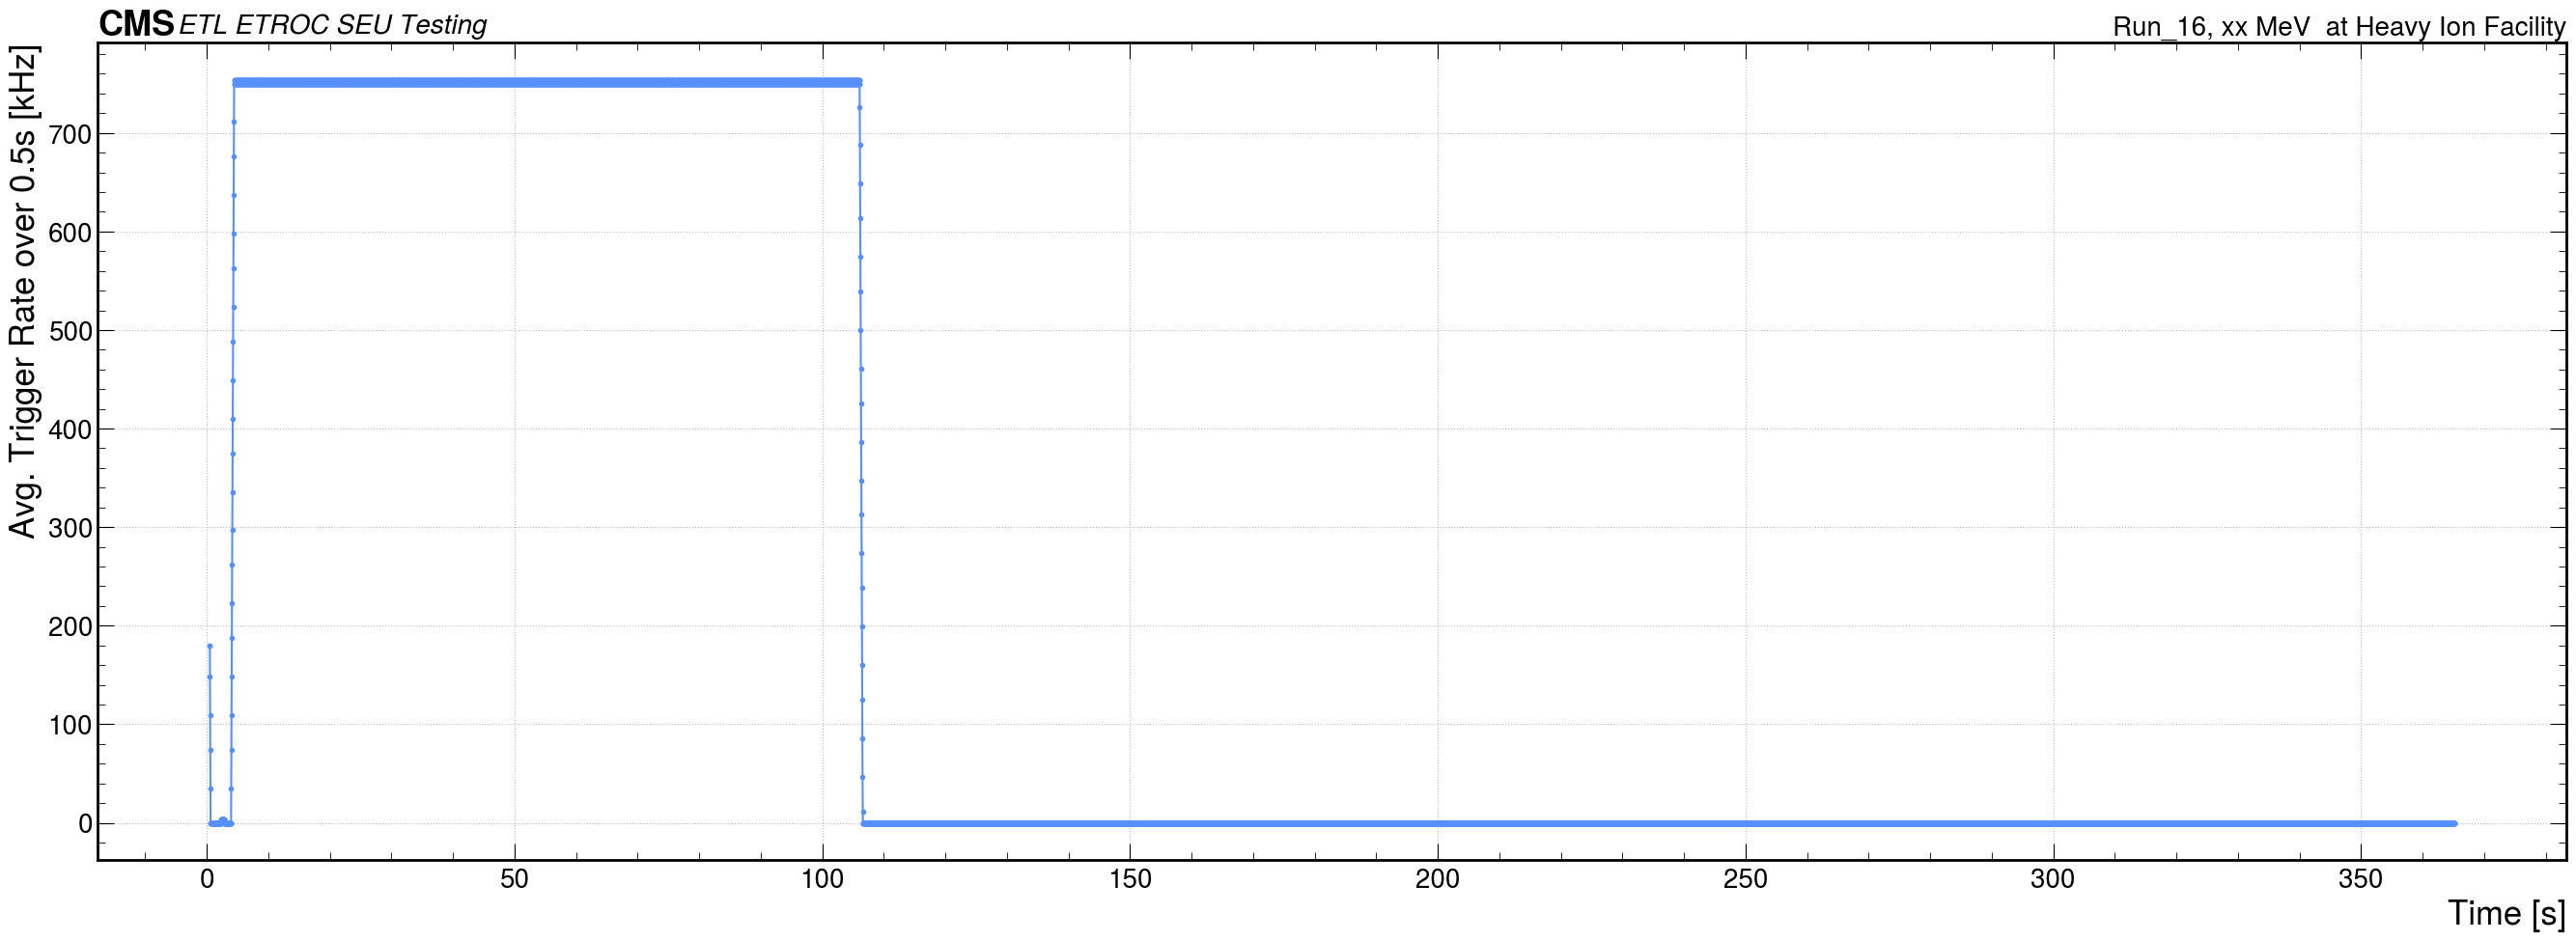

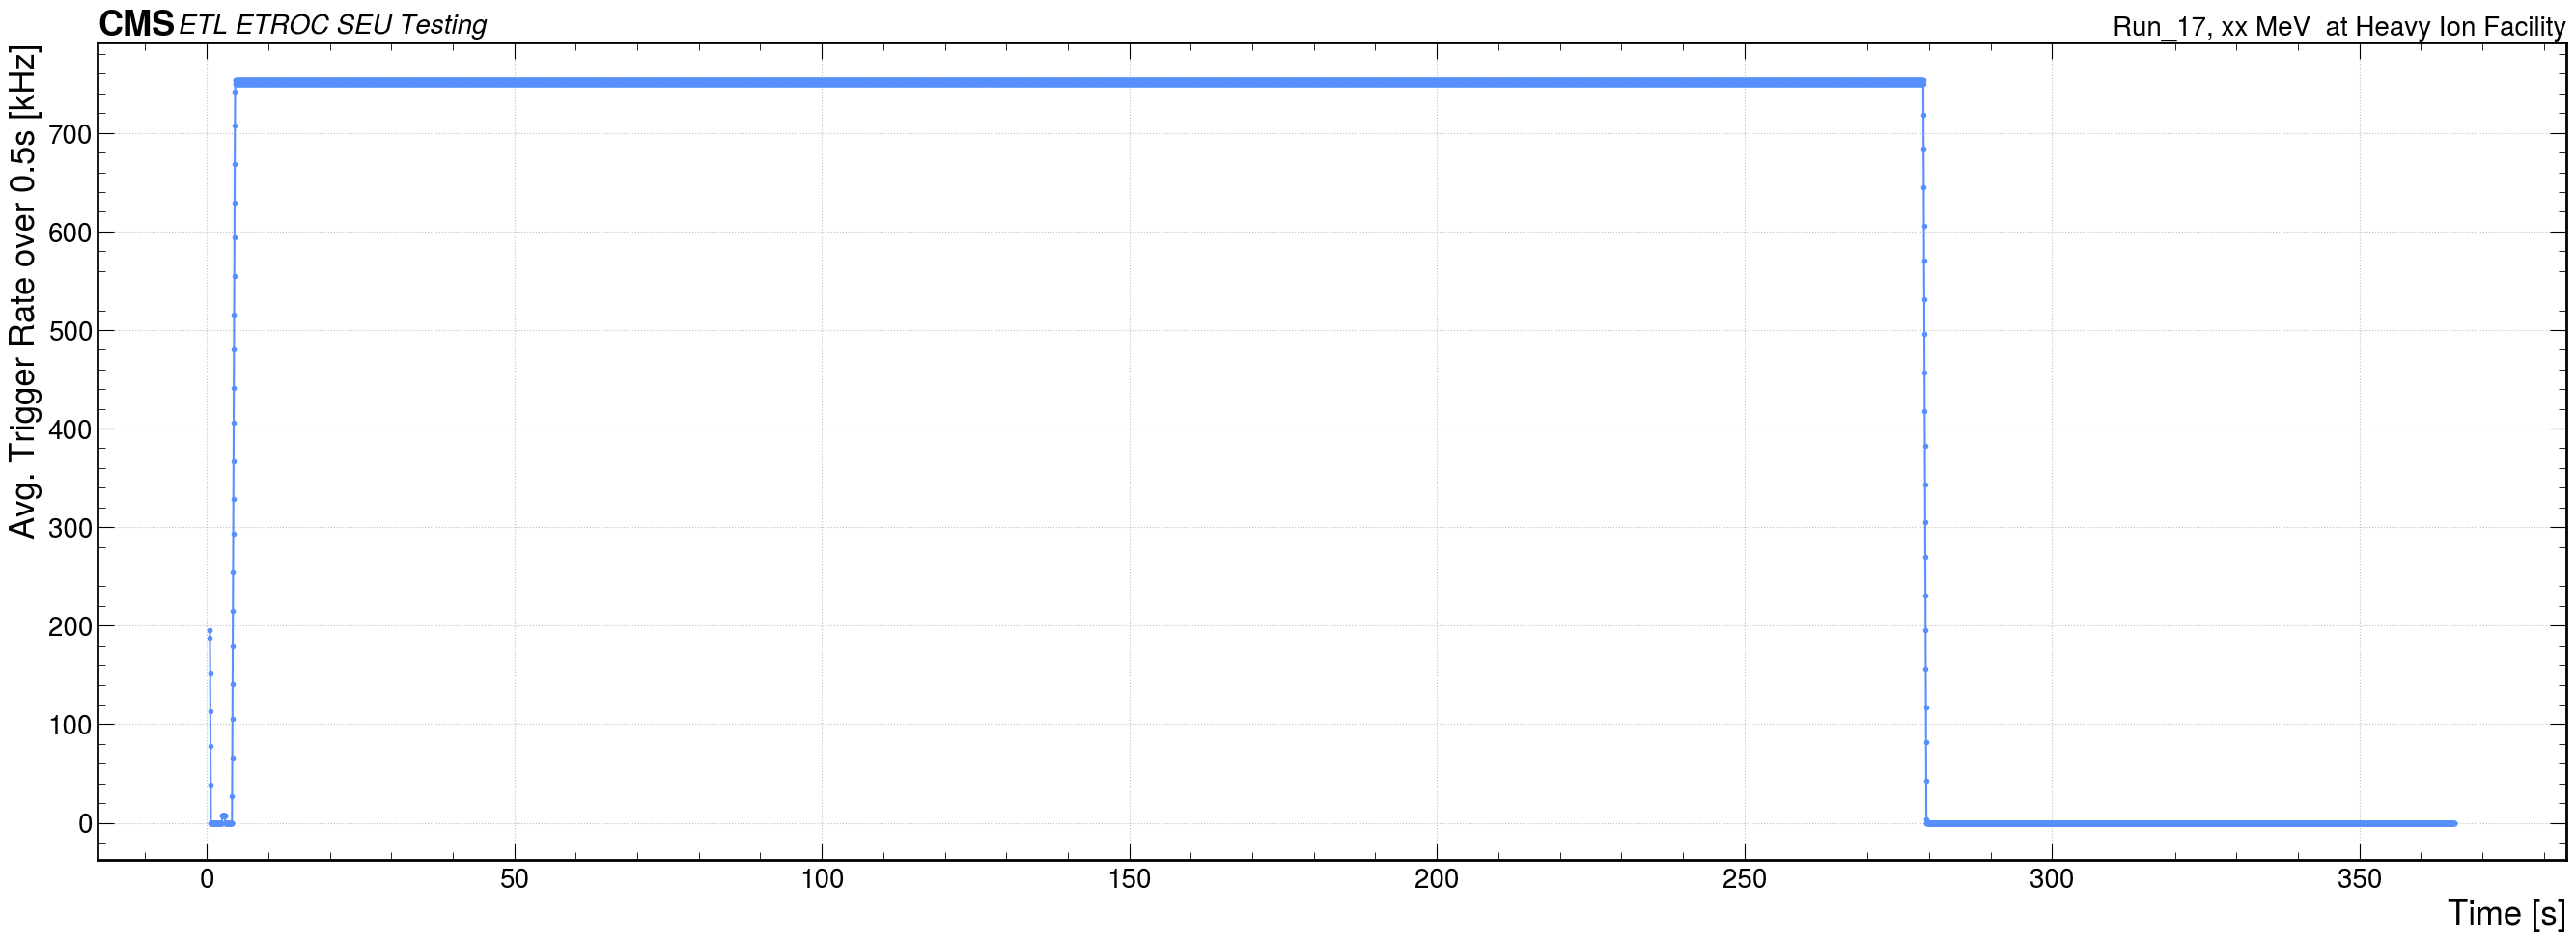

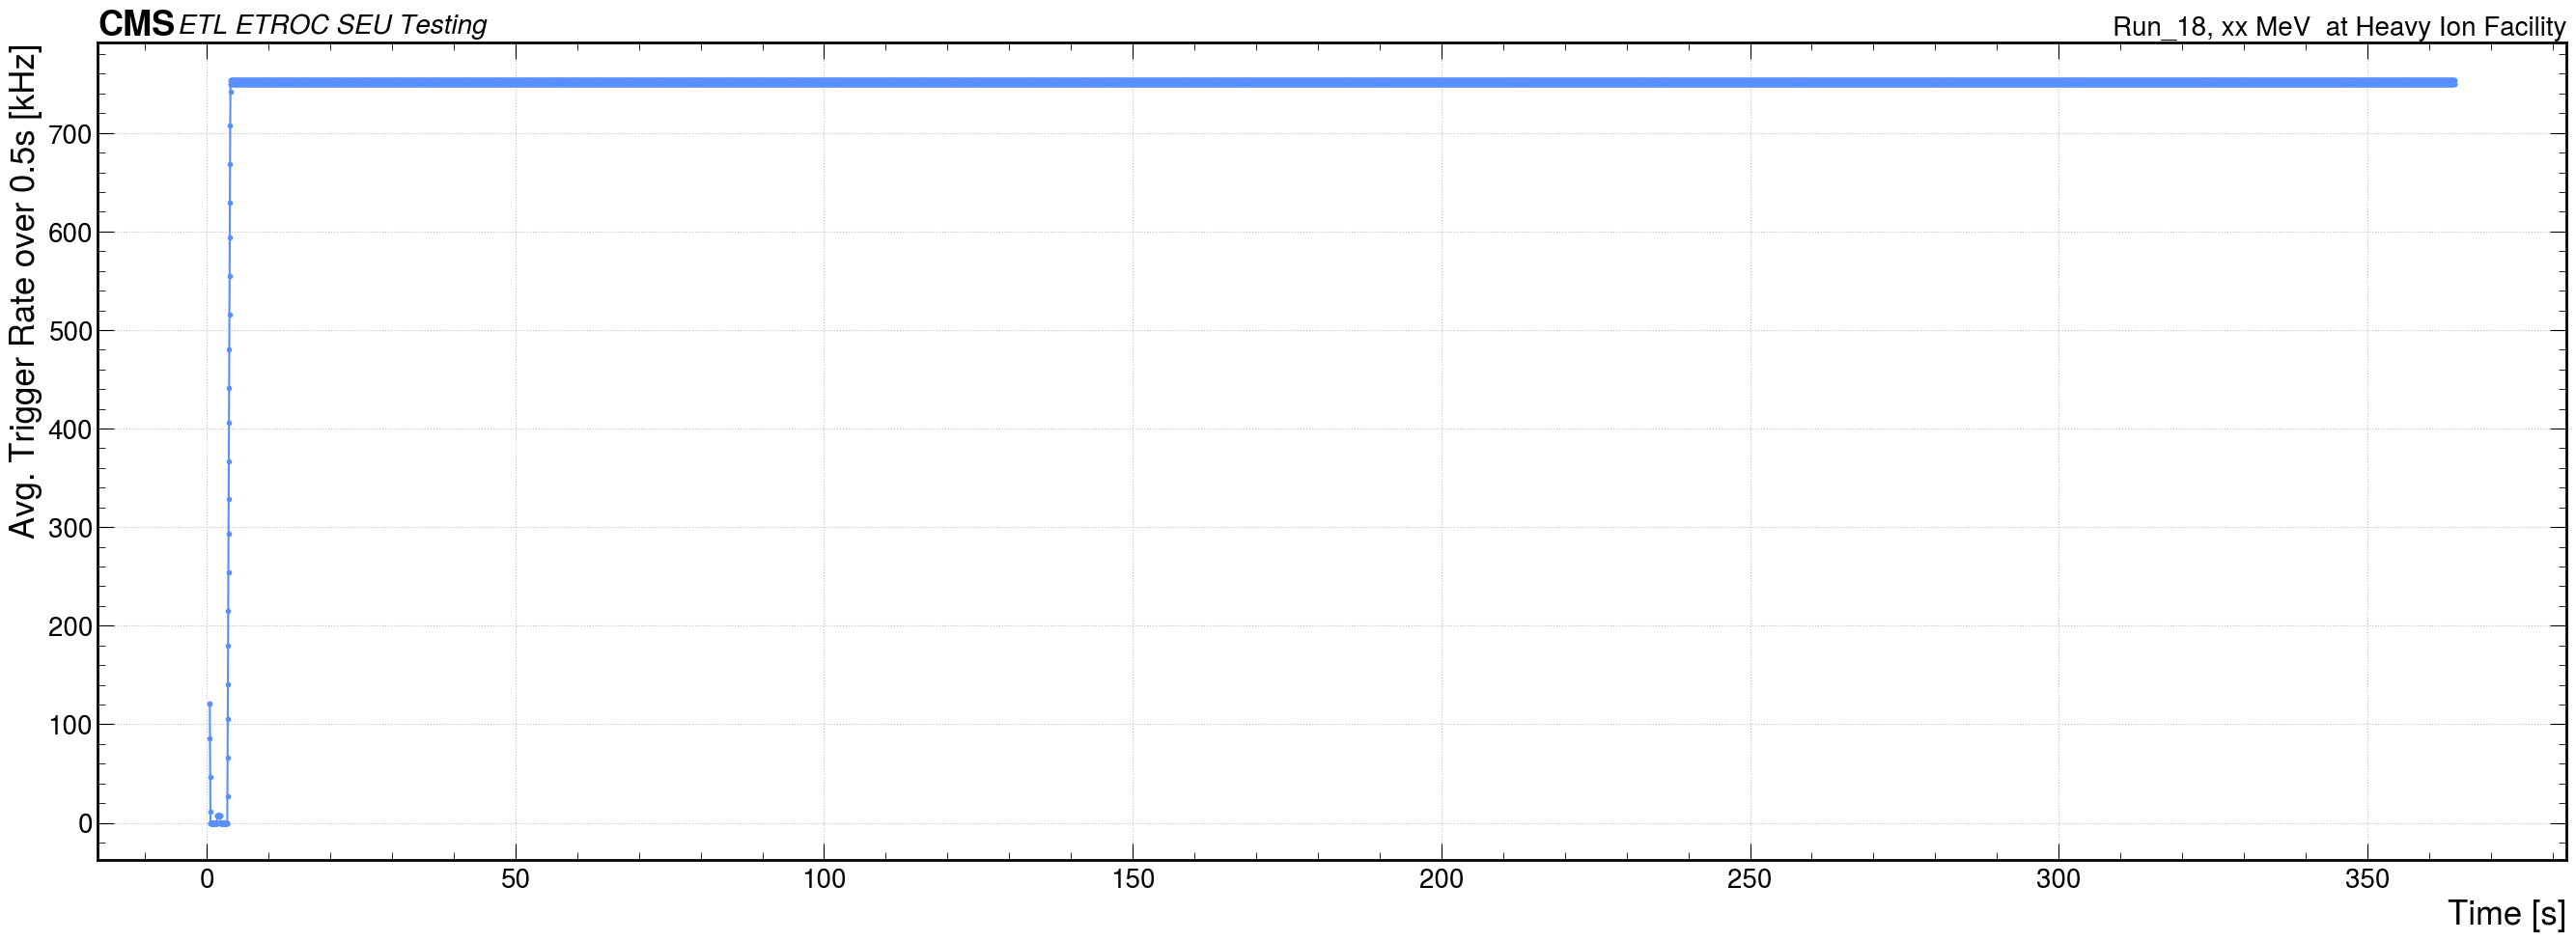

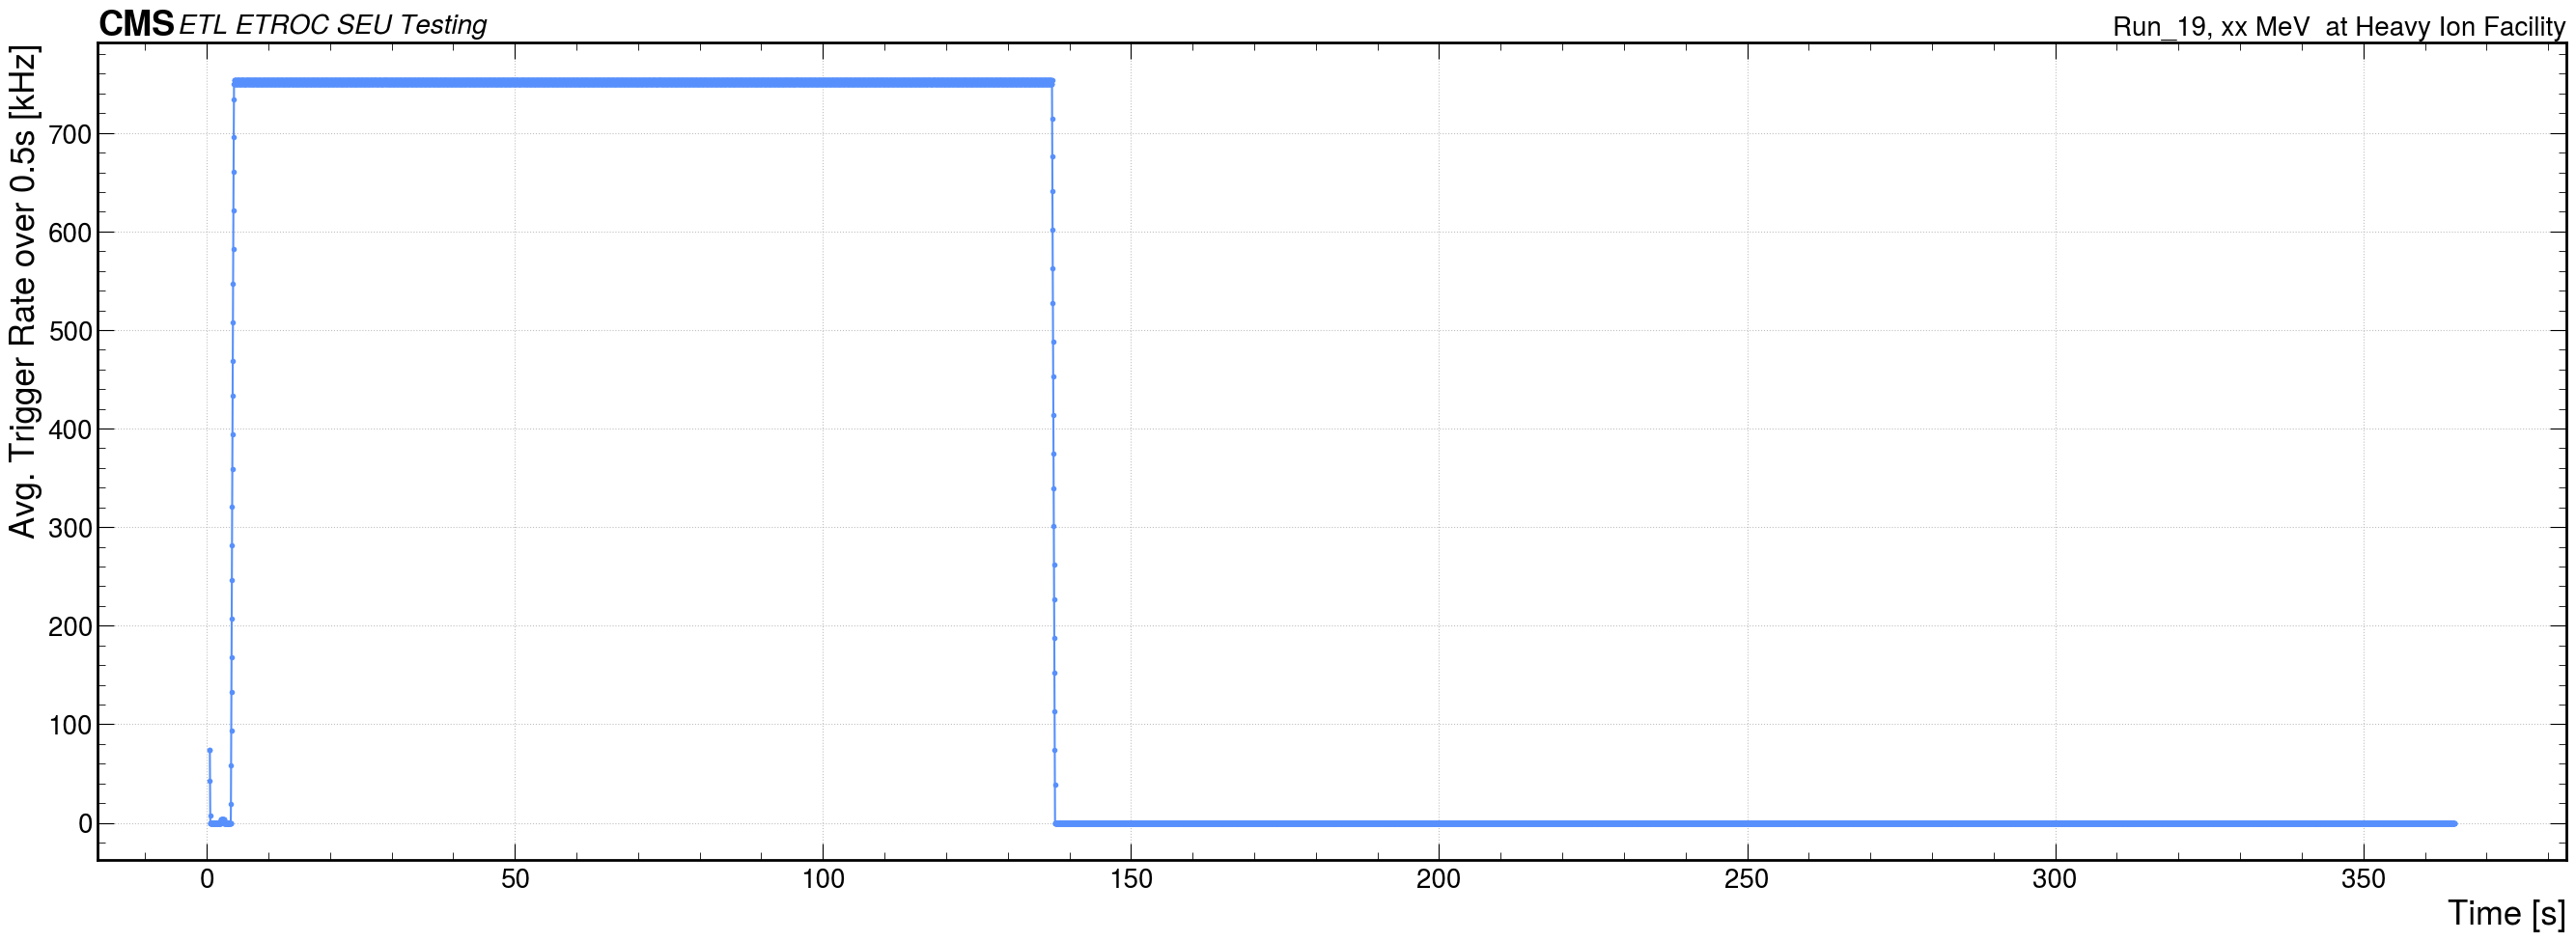

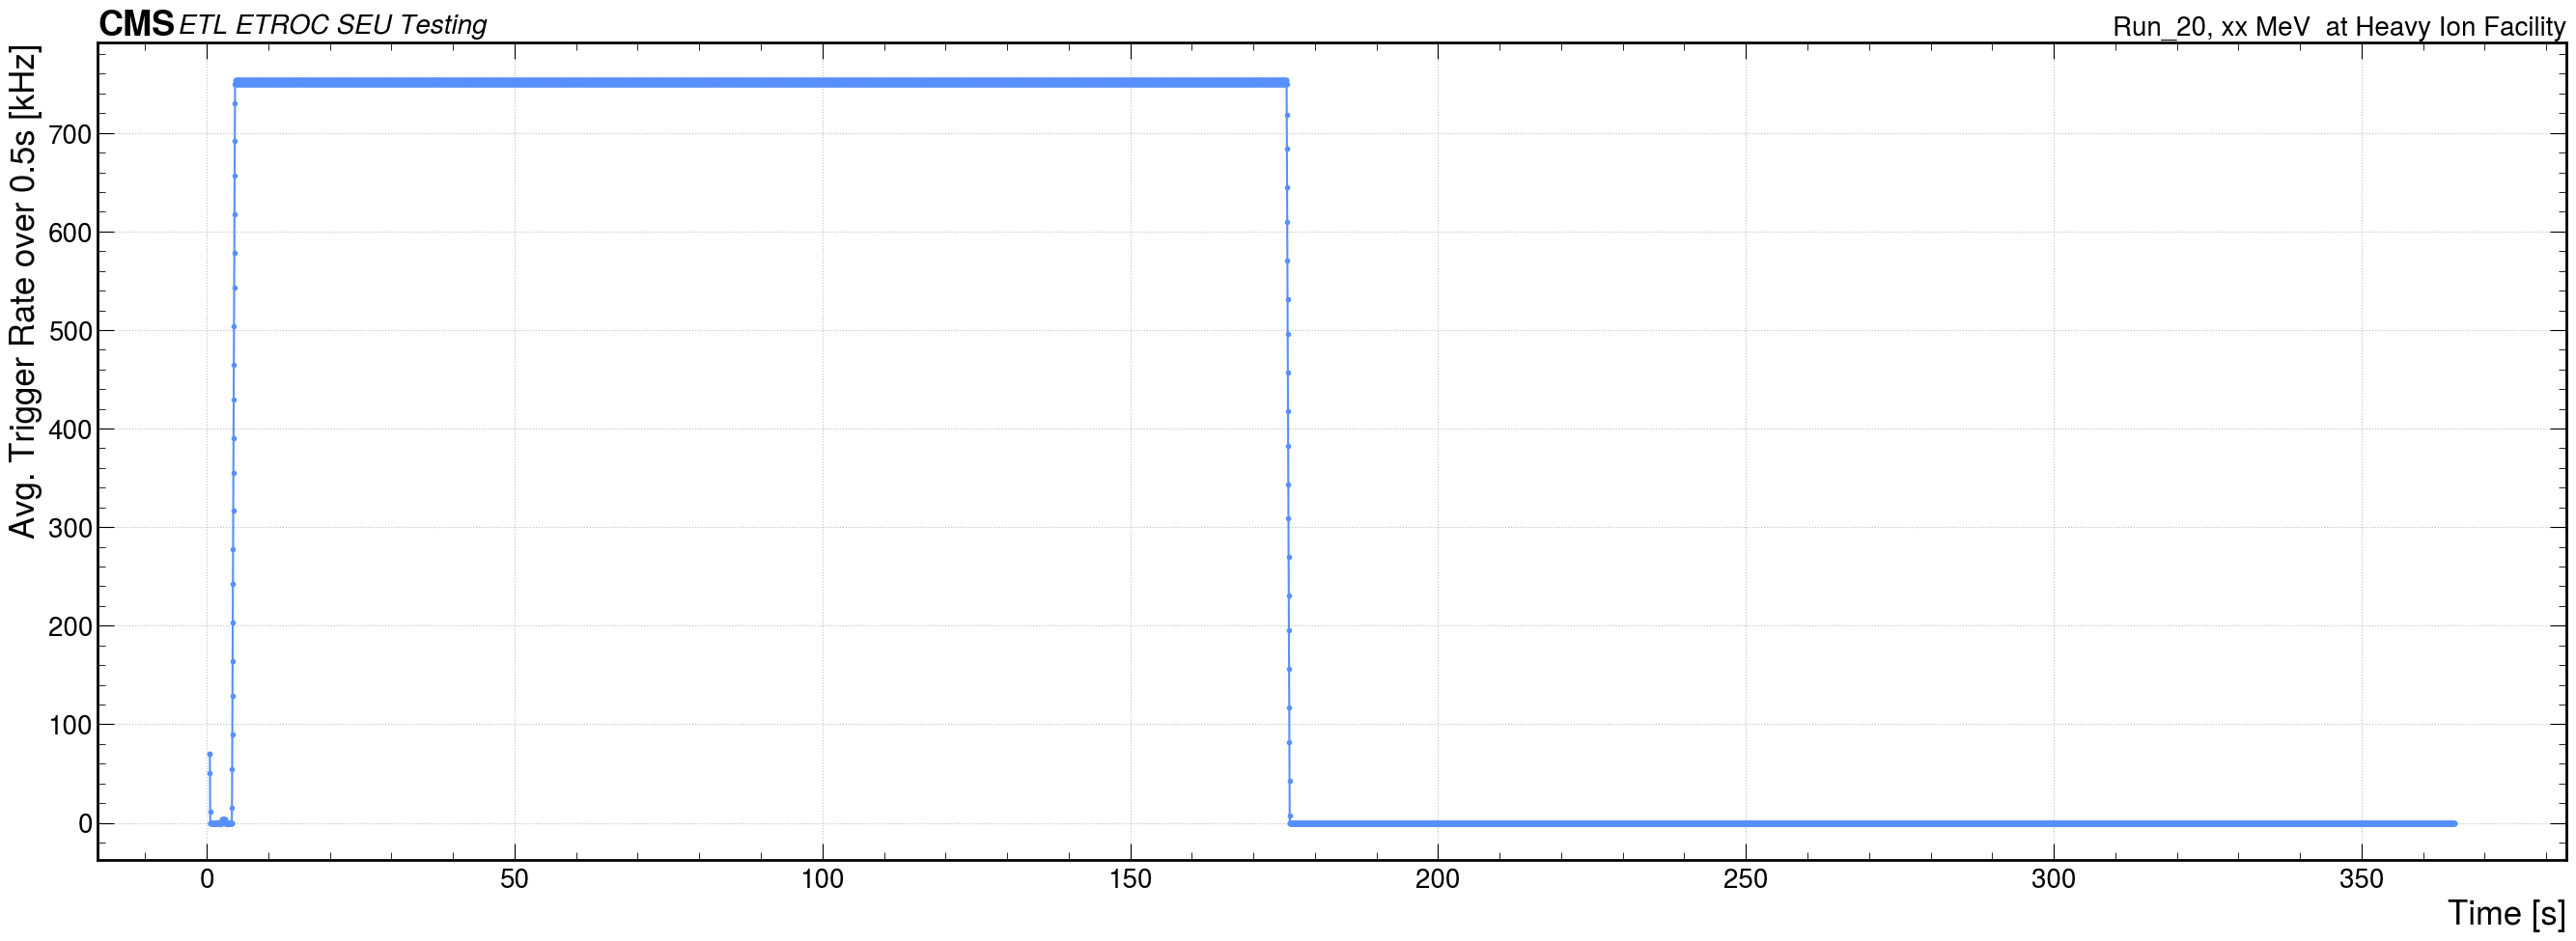

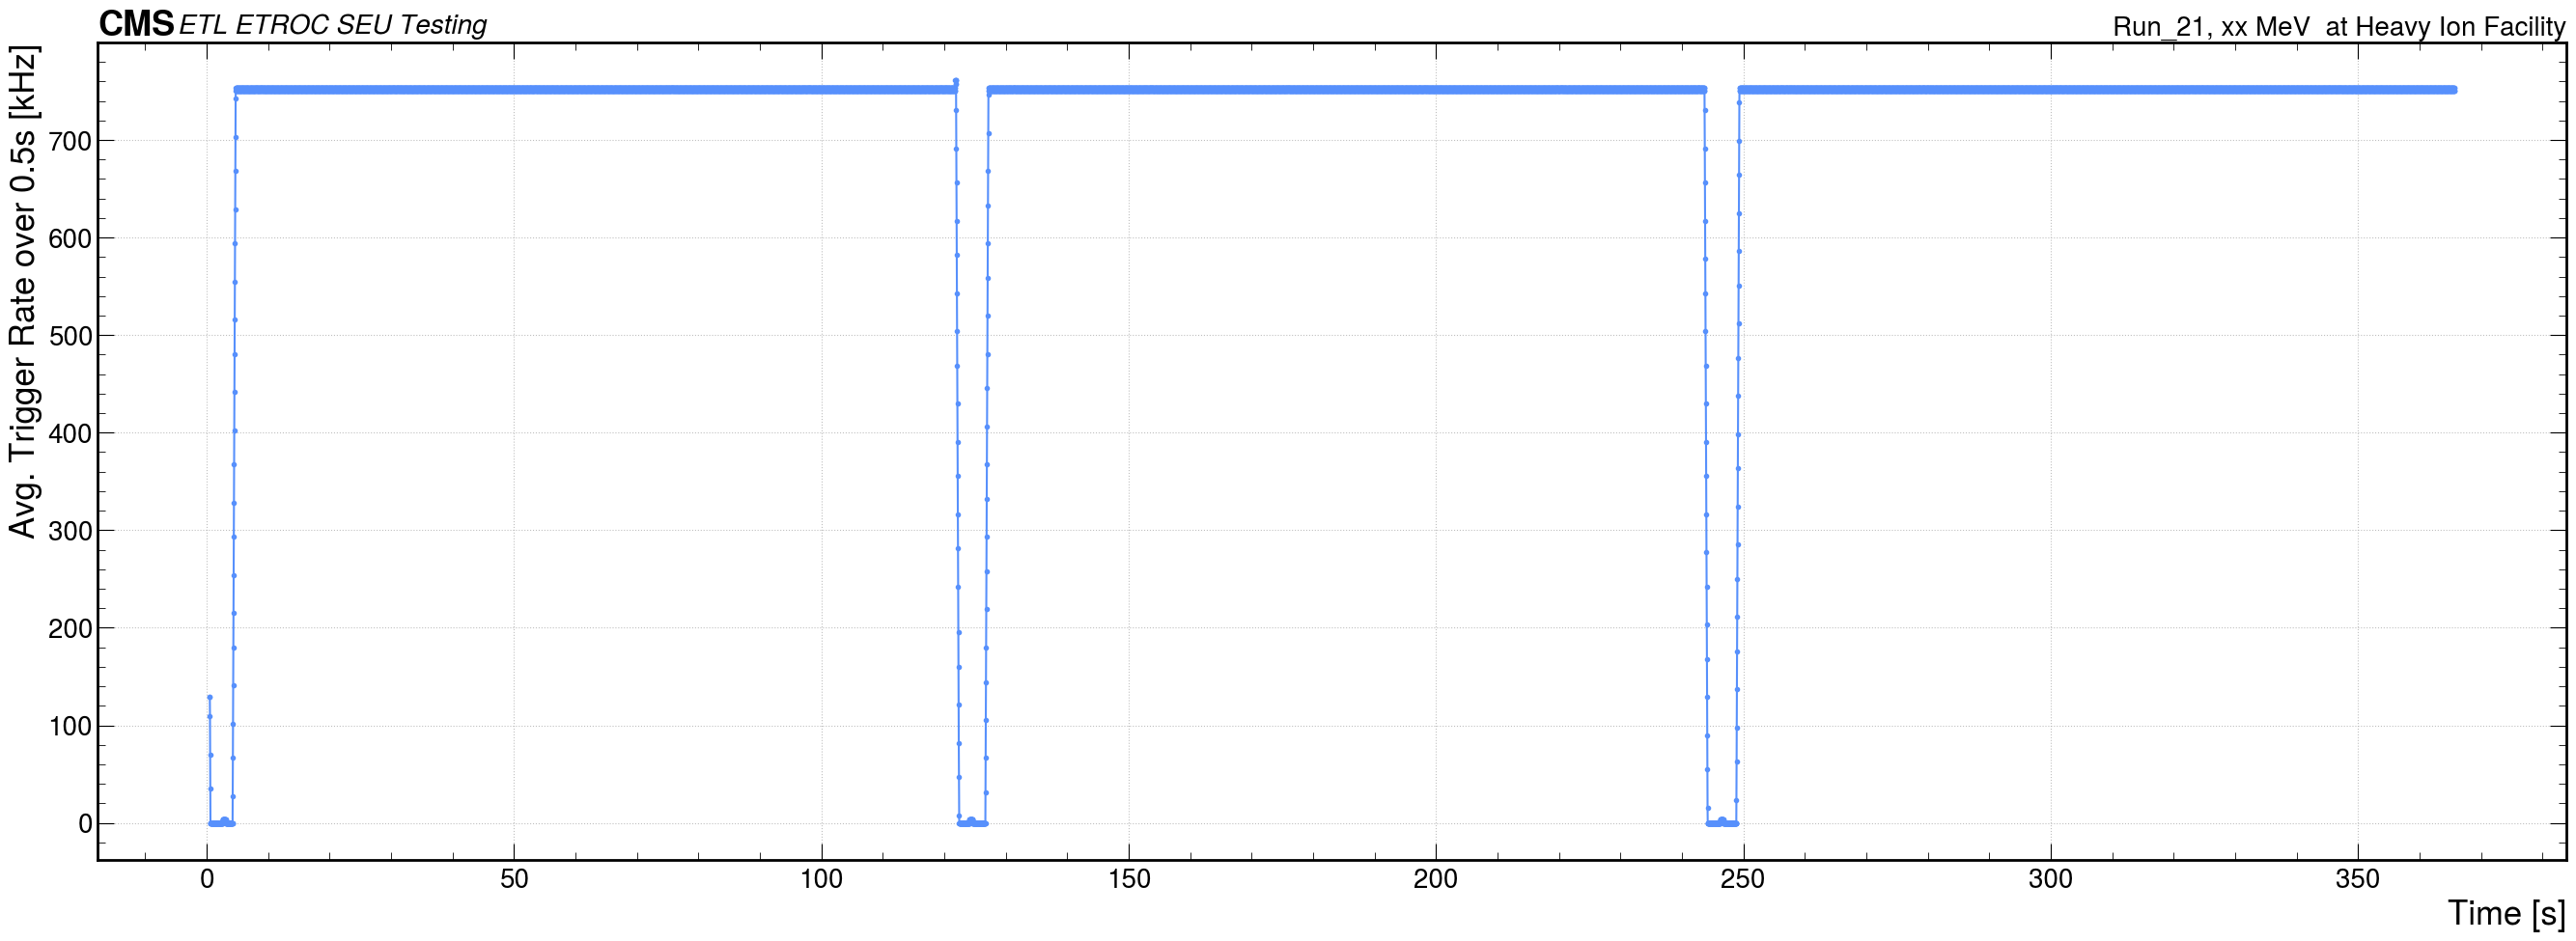

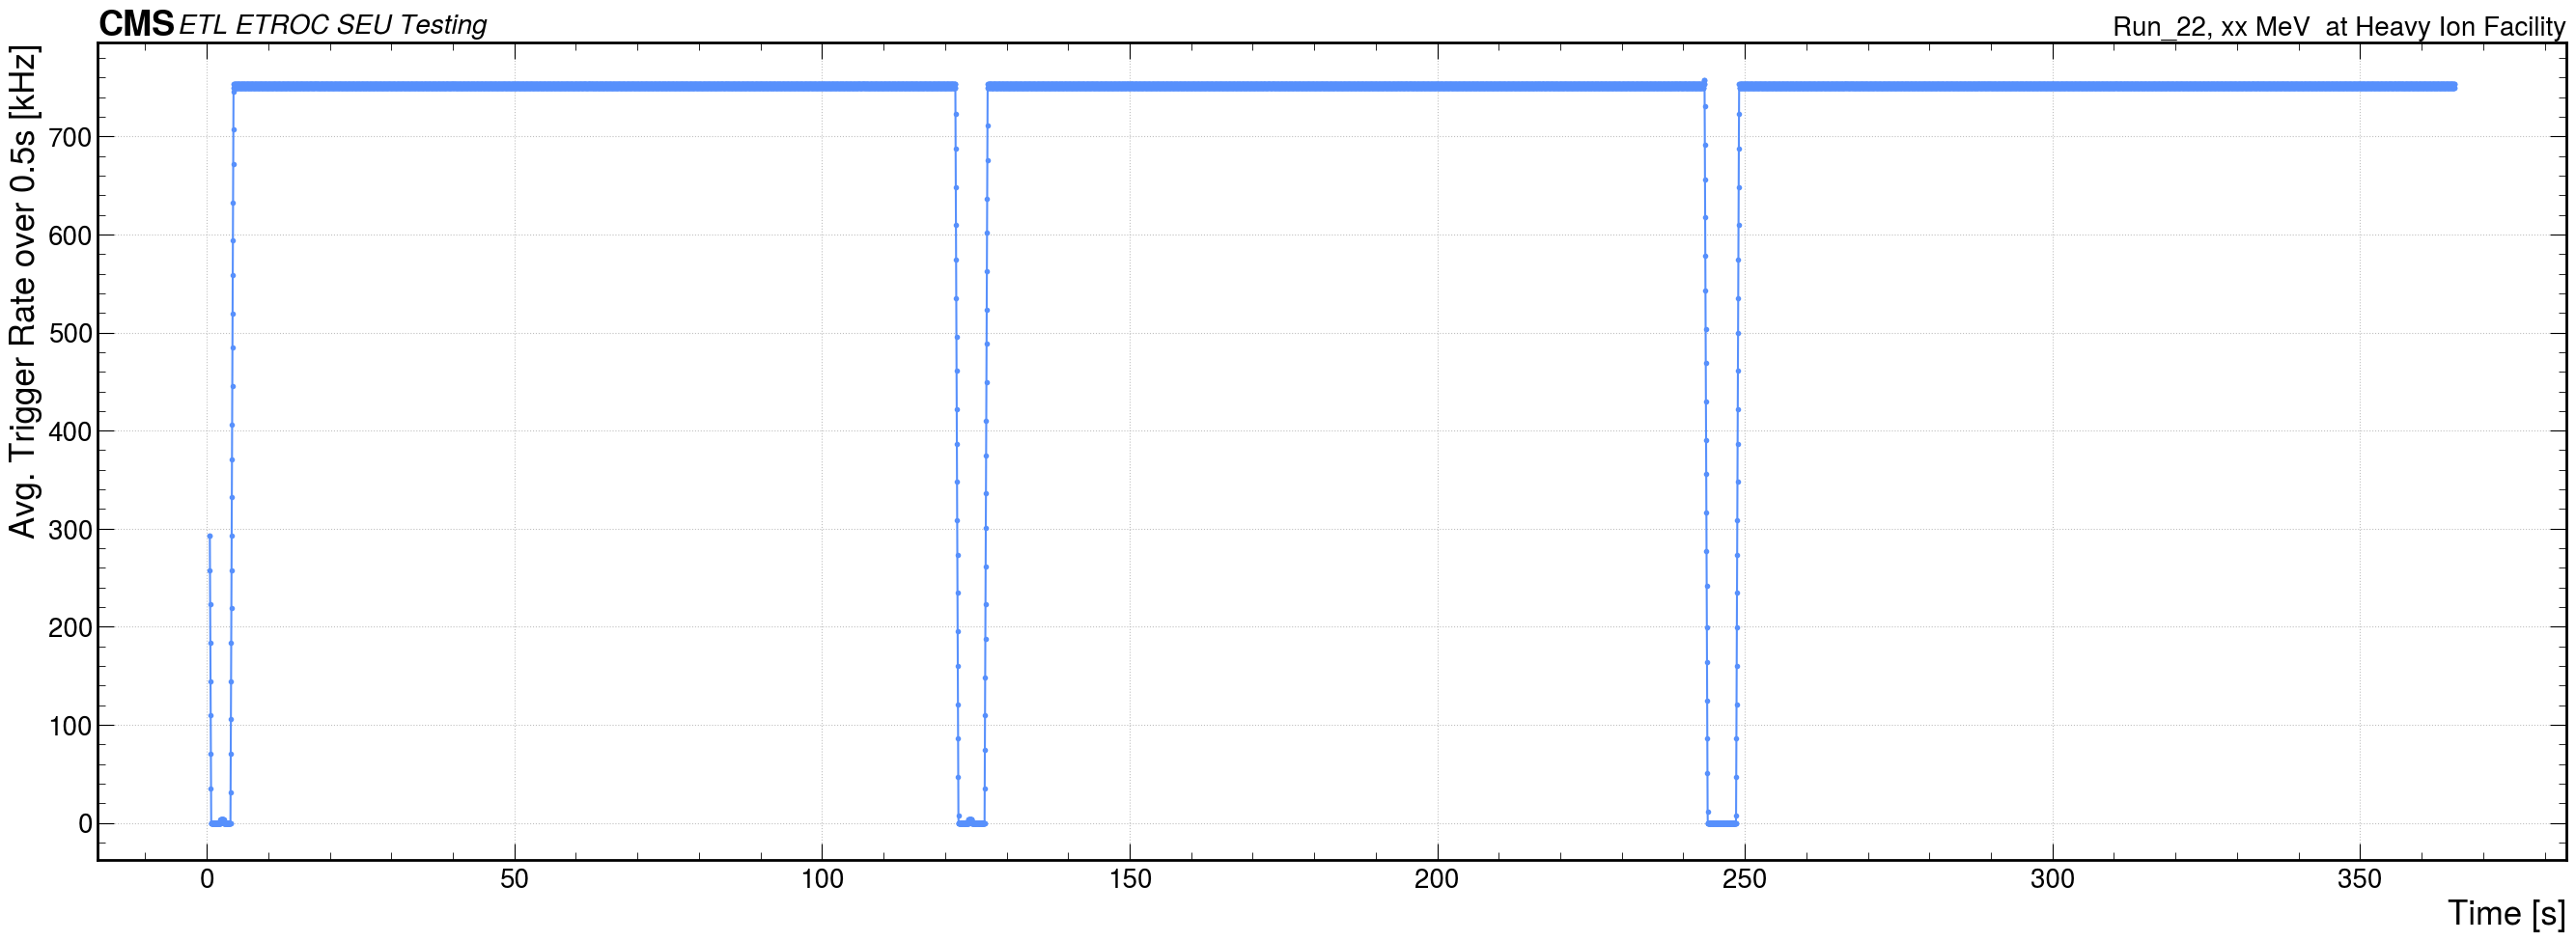

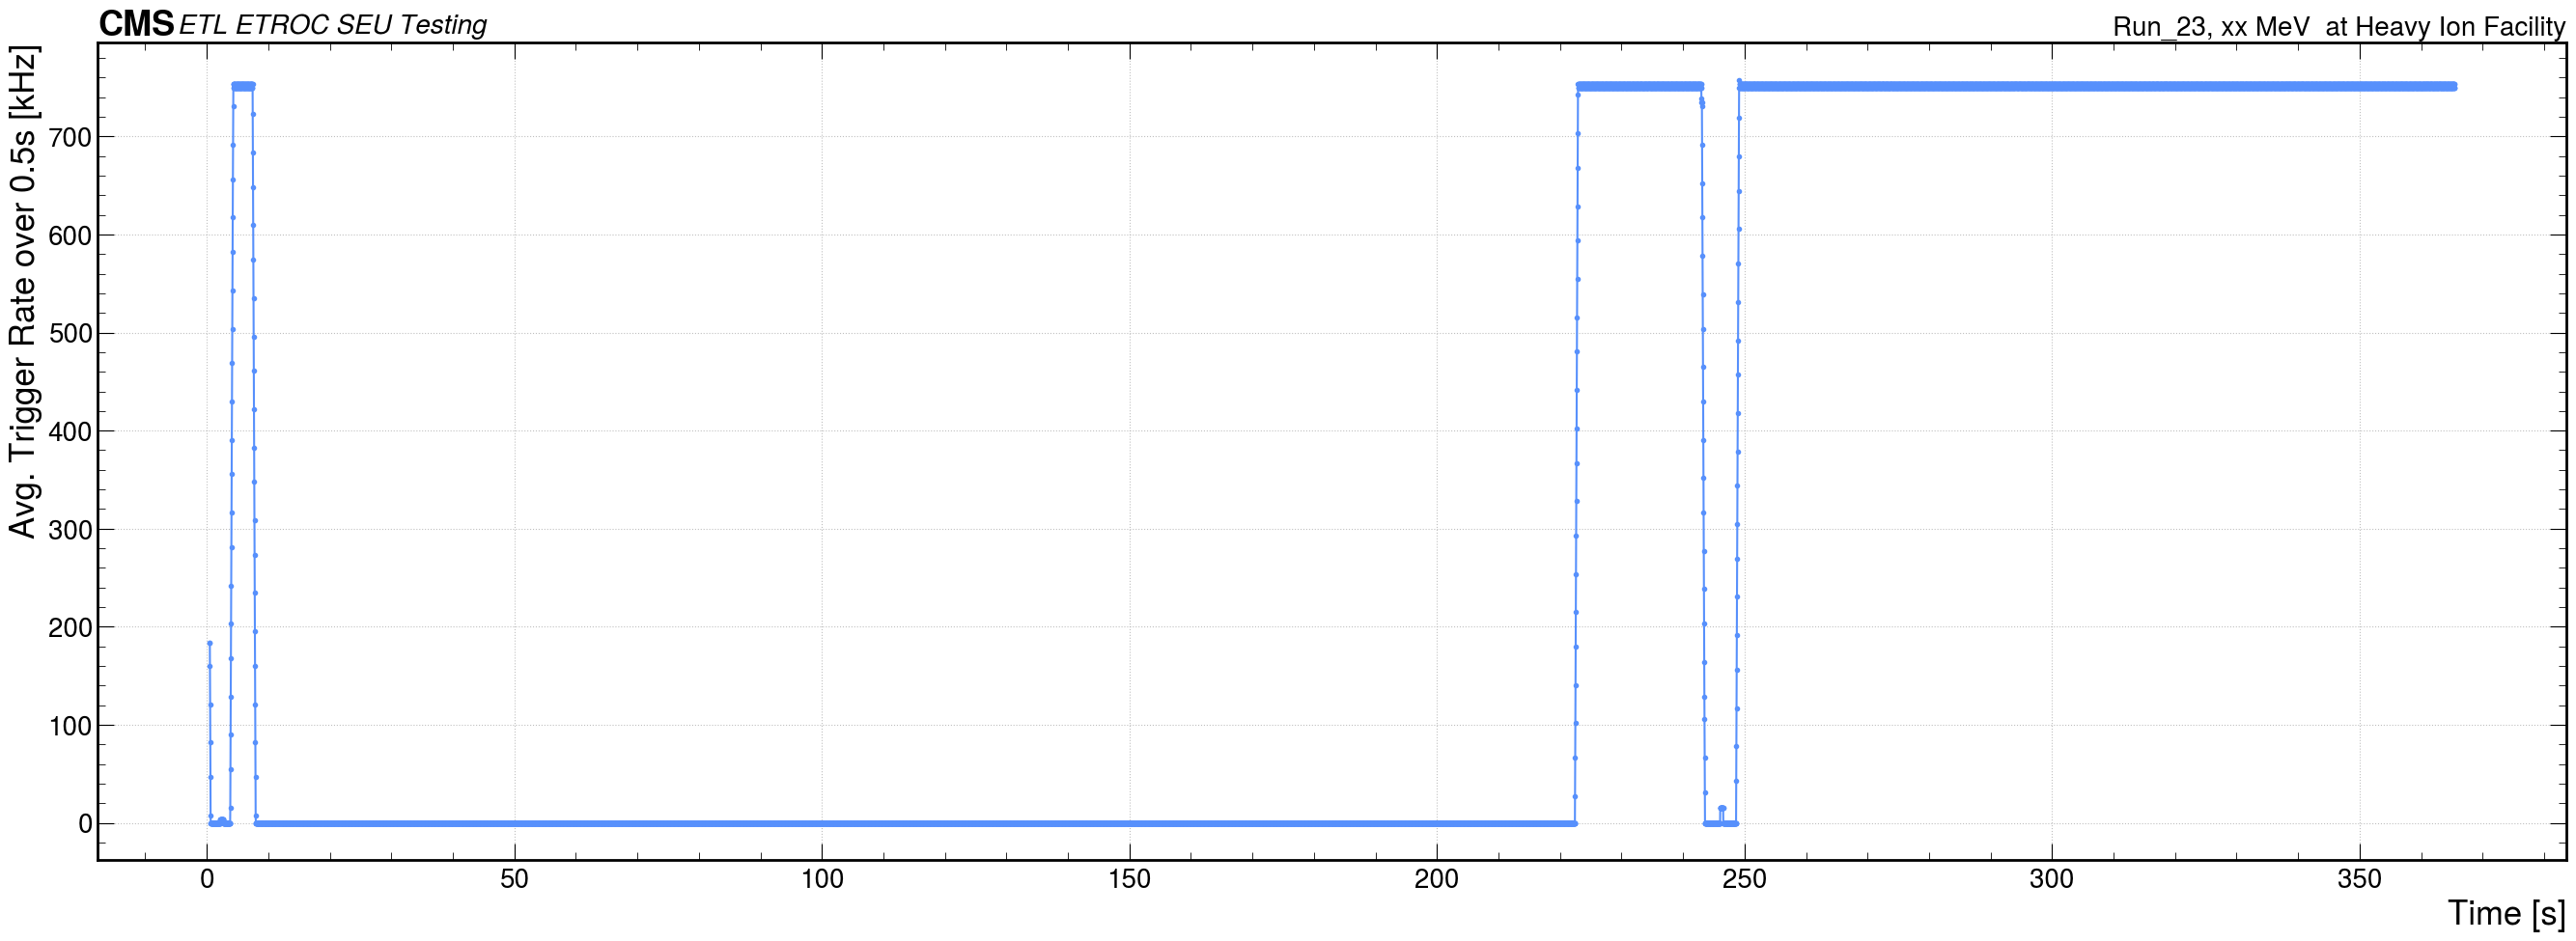

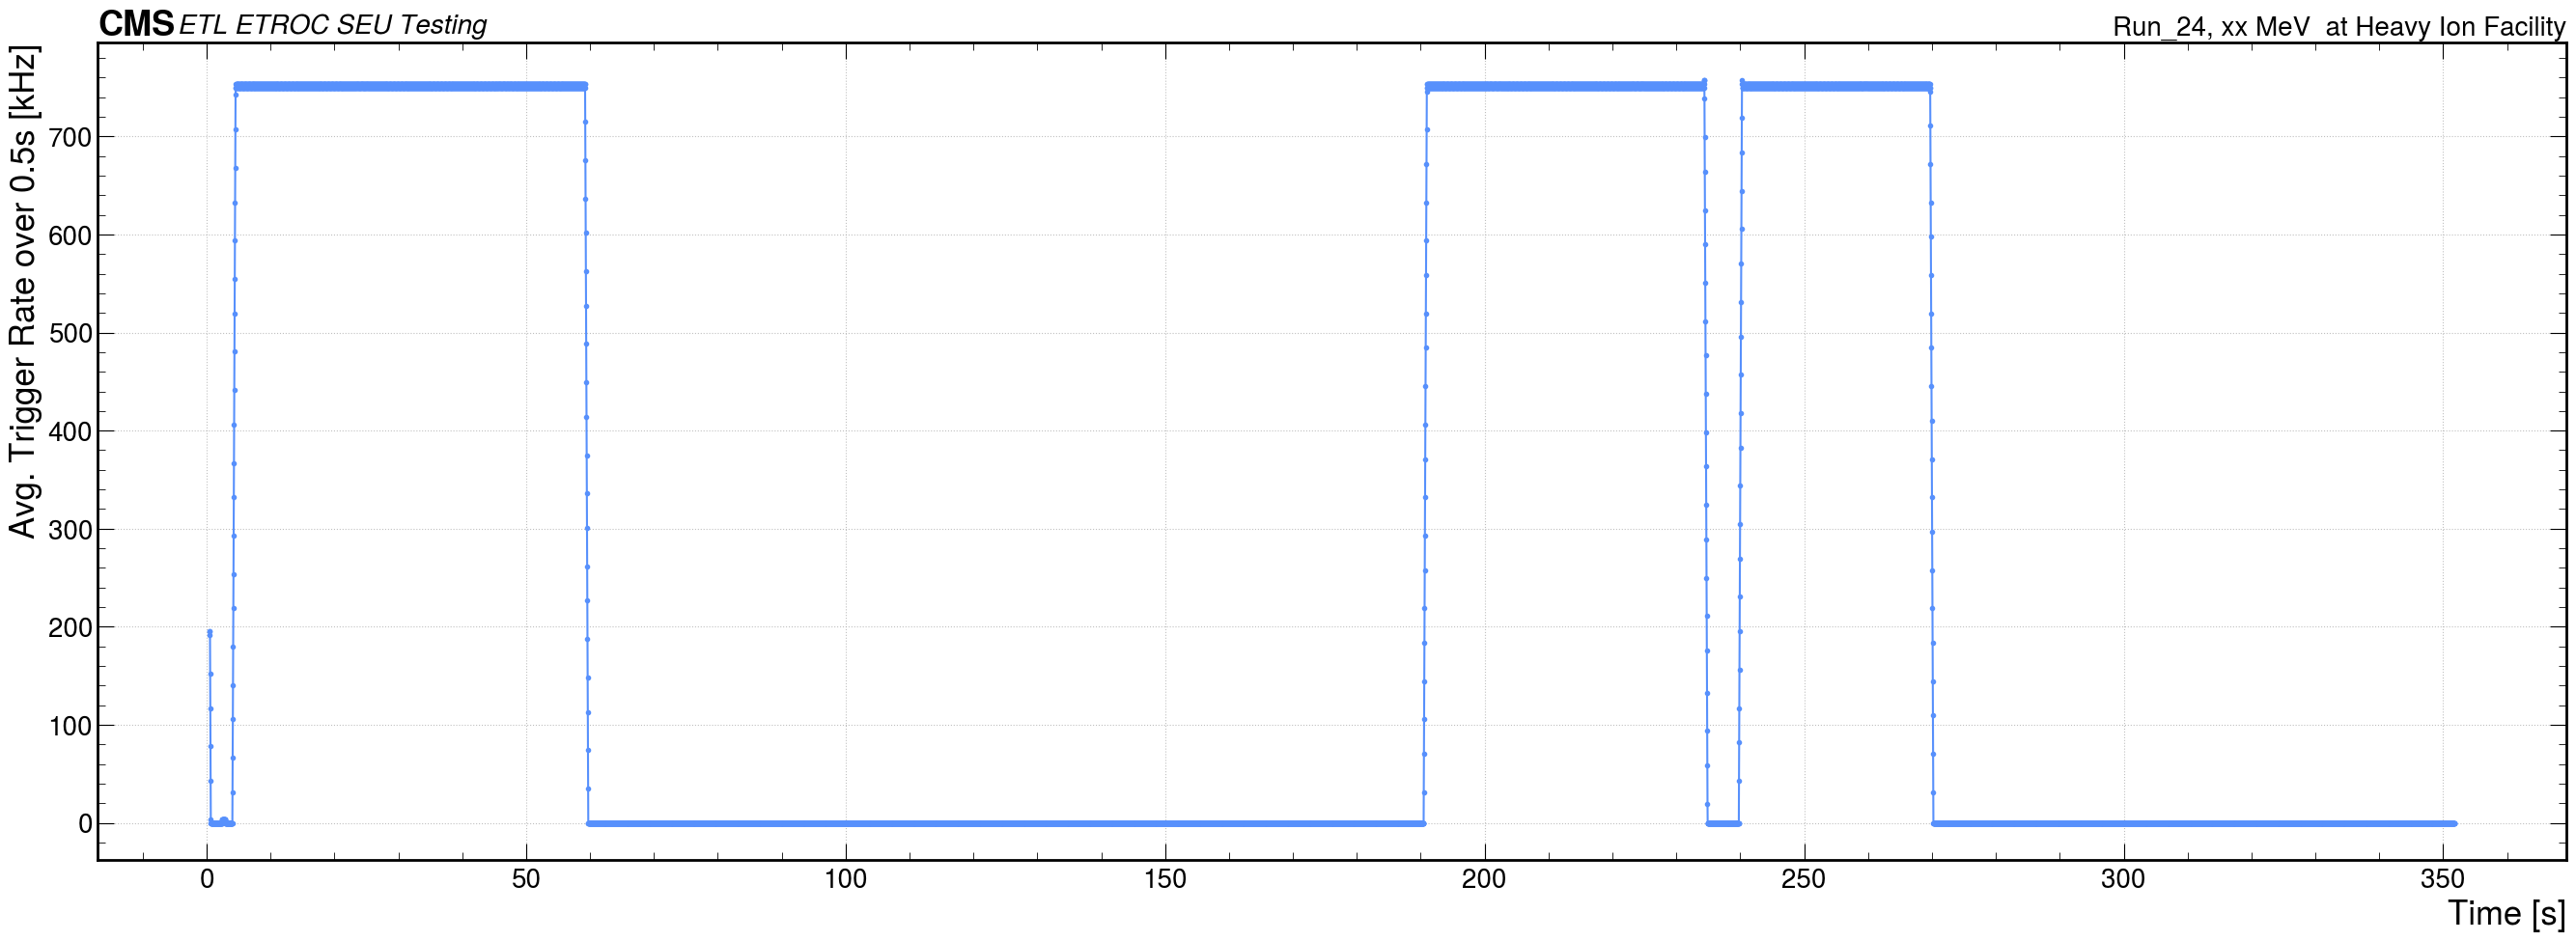

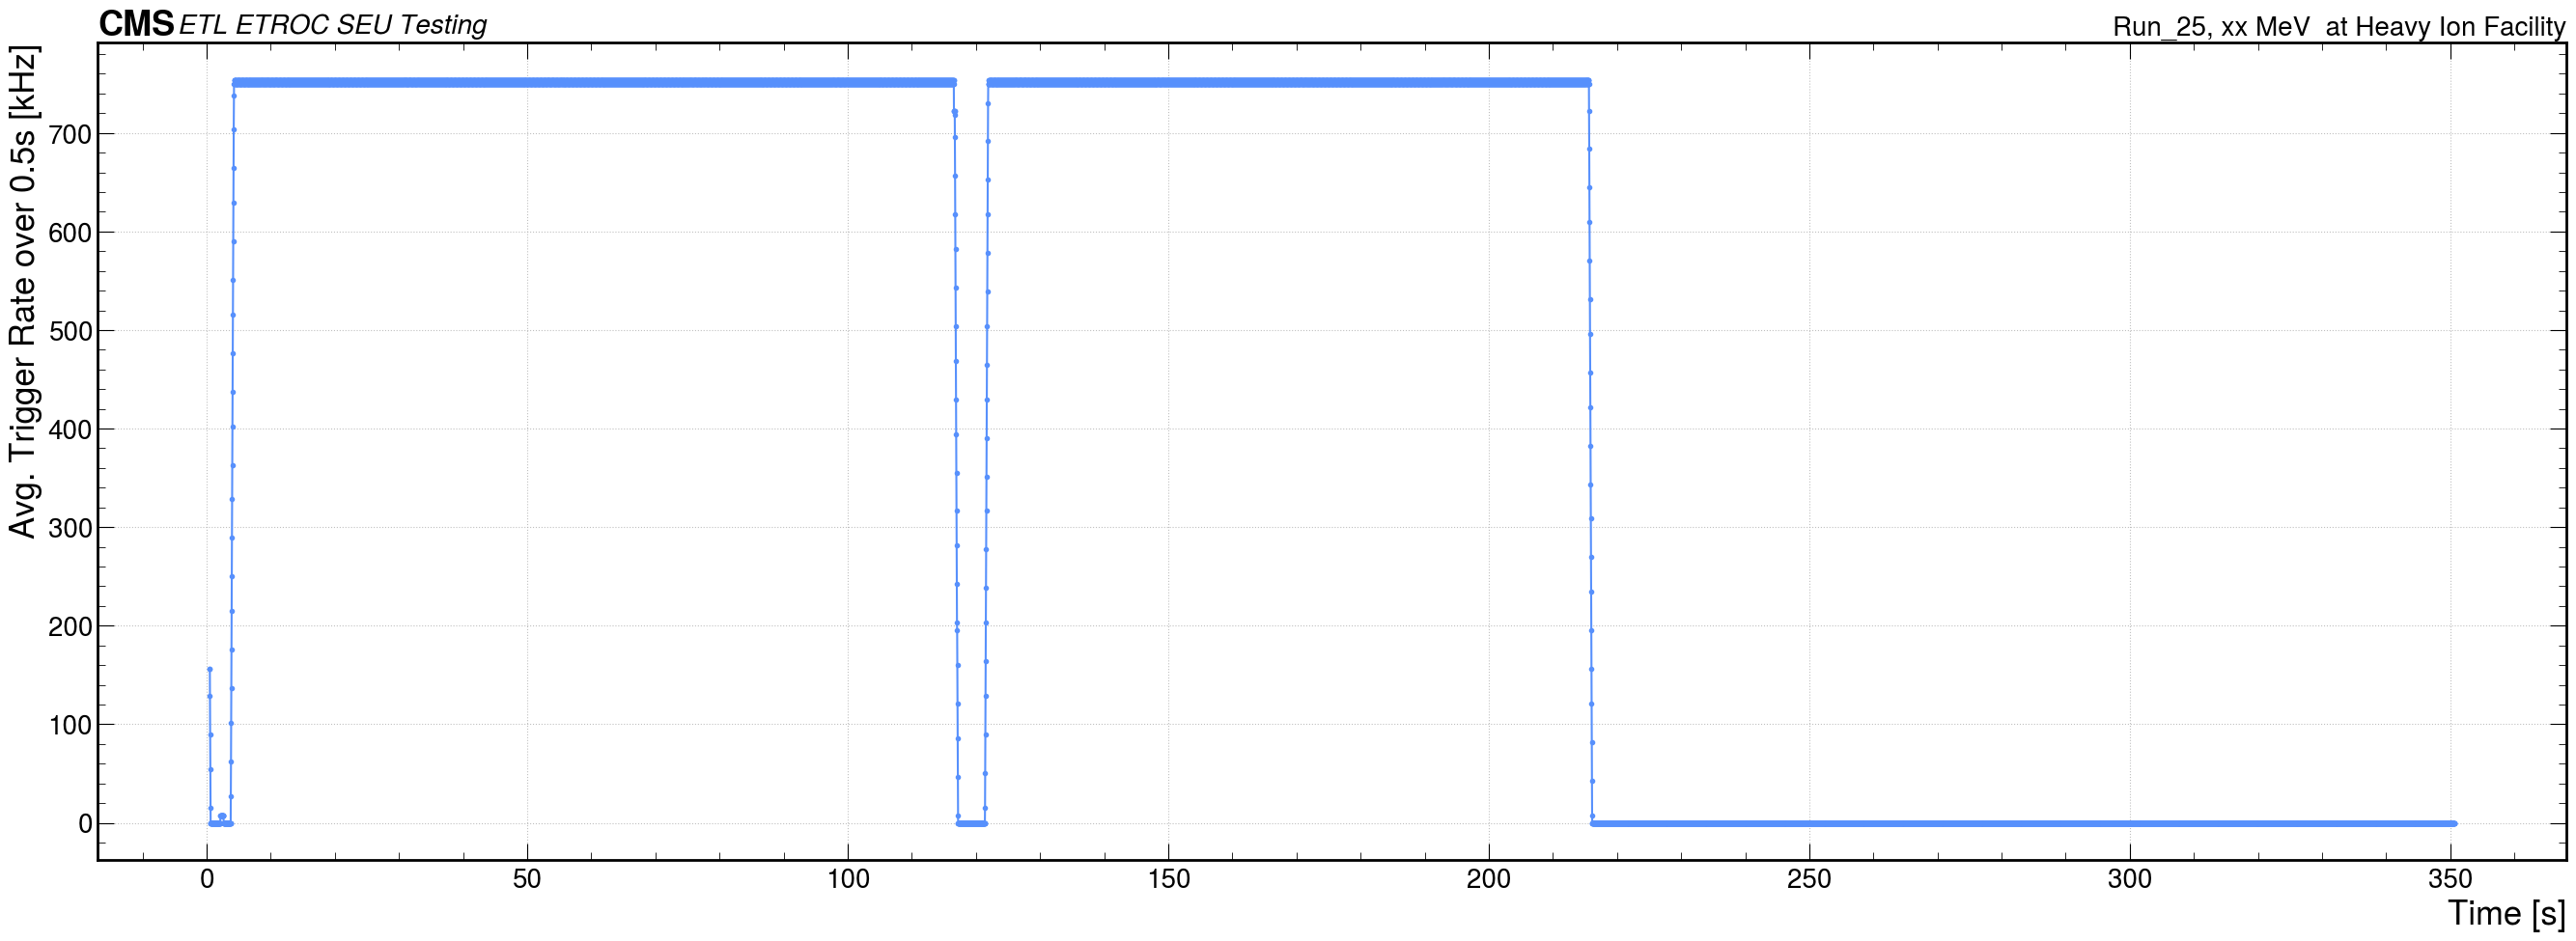

In [54]:
prescale = 2048
window_size = 20
runs = ["01","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25"]

counter = 0
for this_run in runs:
    counter += 1
    print(f"""Run {counter} Run_{this_run}""")
    #if counter == 12:
    #    break
    #if counter < 11:
    #    continue
    # plotRunSummary(this_run_info, translated_dir, plot_dir, "louvain", True)
    with sqlite3.connect(translated_dir/f"""Run_{this_run}.sqlite""") as sqlite3_connection:
        filler_dataframe = pandas.read_sql('SELECT * FROM filler_data', sqlite3_connection, index_col=None)

        avg_df = filler_dataframe['events'].rolling(window=window_size).sum().to_frame(name='avg').reset_index()

        plot_title = load_fig_title(tb_loc='louvain')

        fig, ax = plt.subplots(figsize=(33, 11))
        hep.cms.text(loc=0, ax=ax, text="ETL ETROC SEU Testing", fontsize=20)
        ax.set_title(f'Run_{this_run}, {plot_title}', loc='right', fontsize=20)
        ax.plot(avg_df['index']*0.025, prescale*avg_df['avg']*1e-3/(window_size*0.025*1.024**2), '.-')

        ax.set_xlabel('Time [s]', fontsize=25)
        ax.tick_params(axis='both', labelsize=20)
        ax.set_ylabel('Avg. Trigger Rate over 0.5s [kHz]', fontsize=25)
        ax.grid()

In [55]:
import numpy as np
prescale = 2048
window_size = 20
runs = ["01","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25"]
counter = 0
for this_run in runs:
    counter += 1
    # print(f"""Run {counter} Run_{this_run}""")
    # if counter == 3:
    #    break
    #if counter < 11:
    #    continue
    # plotRunSummary(this_run_info, translated_dir, plot_dir, "louvain", True)
    with sqlite3.connect(translated_dir/f"""Run_{this_run}.sqlite""") as sqlite3_connection:
        events_dataframe = pandas.read_sql('SELECT * FROM event_data', sqlite3_connection, index_col=None)
        # print(events_dataframe.info())
        # print(events_dataframe['hits_counter'])
        count_not_one = (events_dataframe["hits_counter"] < 1).sum()
        print(f"""Run_{this_run}""", events_dataframe['evt'].count(), count_not_one)

Run_01 109606 0
Run_1 263804 0
Run_2 136721 0
Run_3 262969 0
Run_4 262969 0
Run_5 394202 0
Run_6 394251 0
Run_7 394204 0
Run_8 394204 0
Run_9 316136 0
Run_10 394263 0
Run_11 394236 0
Run_12 394117 0
Run_13 367572 272417
Run_14 3336 0
Run_15 140858 0
Run_16 39368 0
Run_17 105918 0
Run_18 138949 0
Run_19 51327 0
Run_20 65976 0
Run_21 135387 0
Run_22 135464 0
Run_23 54369 49760
Run_24 49748 0
Run_25 79793 0
